In [1]:
using Gen
using PyPlot
using Statistics: mean, std;

include("./rendering.jl") 
include("./extra_distributions.jl") 
include("./gammatonegram.jl")
include("./plotting.jl");

## Generative Model

In [2]:
@dist part_dist(lambda) = geometric(lambda) + 1

@gen function source_latents(audio_sr::Int)
    
    # Source Parameters 
    mu = @trace(uniform(freq_to_ERB(20.0), freq_to_ERB(audio_sr/2.)), :mu)
    # Number of tones 
    n_tones = @trace(part_dist(0.2), :n_tones)
    
    return mu, n_tones
    
end

@dist dur_dist(shape, scale, min_duration) = gamma(2, 0.1) + min_duration

@gen function generate_source(audio_sr::Int, scene_duration::Float64)
    
    #Generate source level latent variables 
    mu, n_tones = @trace(source_latents(audio_sr))
    
    # generate onset and duration for each tone
    onsets = Vector{Float64}(undef, n_tones)
    offsets = Vector{Float64}(undef, n_tones)
    f0s = Vector{Float64}(undef, n_tones)
    for tone_idx=1:n_tones
        
        # tone_idx == 1 ? @trace(uniform(0, scene_duration), (:tone, tone_idx) => :gap) : .. causes problems in the switch inference move
        gap = @trace(gamma(2,0.1), (:tone, tone_idx) => :gap)
        tone_duration = @trace(dur_dist(2,0.1,0.050), (:tone, tone_idx) => :duration) 
        f0s[tone_idx] = @trace(normal(mu, 3.0),(:tone, tone_idx) => :f0)
        
        onsets[tone_idx] = (tone_idx == 1 ? 0 : offsets[tone_idx - 1]) + gap; 
        offsets[tone_idx] = onsets[tone_idx] + tone_duration; 
        
    end

    element_waves = [generate_tone_wave(f0s[tone_idx], onsets[tone_idx], 
            offsets[tone_idx], audio_sr, scene_duration) for tone_idx = 1:n_tones]

    #Sum over all tones to produce source waveform 
    n_samples = Int(floor(scene_duration*audio_sr));
    source_wave = reduce(+, element_waves; init=zeros(n_samples))

    return source_wave
    
end;
generate_sources = Map(generate_source);

In [3]:
@gen function generate_scene(scene_duration::Float64, audio_sr::Int, 
                        wts::Array{Float64,1}, gtg_params::GammatonegramParams)
    
    # how many sources are there
    n_sources = @trace(part_dist(0.6), :n_sources)
    source_waves = @trace(generate_sources(fill(audio_sr,n_sources),fill(scene_duration,n_sources)),:source)

    # sum over all sources to produce scene waveform
    n_samples = Int(floor(scene_duration*audio_sr))
    scene_wave = reduce(+, source_waves; init=zeros(n_samples))
    
    # generate spectrogram from saveform
    scene_gram, t = gammatonegram(scene_wave, wts, audio_sr, gtg_params) 
    
    # add observation noise
    @trace(noisy_matrix(scene_gram, 1.0), :scene)
    
    return scene_gram, scene_wave, source_waves
    
end;

# Show simulated scenes

In [4]:
scene_duration = 2.0
audio_sr = 20000
gtg_params = GammatonegramParams(0.025,0.010, 20.0, 64, 0.50, 1e-6, 1e-80, 20.0)
wts, f = gtg_weights(audio_sr,gtg_params)
args = (scene_duration, audio_sr, wts, gtg_params);

In [5]:
trace = simulate(generate_scene, args)
scene_gram, scene_wave, source_waves = get_retval(trace);
println(get_submap(get_choices(trace),:source))

│
└── 1
    │
    ├── :n_tones : 4
    │
    ├── :mu : 10.481637735907562
    │
    ├── (:tone, 2)
    │   │
    │   ├── :f0 : 10.750376334591525
    │   │
    │   ├── :duration : 0.2521260427707361
    │   │
    │   └── :gap : 0.20903757167750228
    │
    ├── (:tone, 4)
    │   │
    │   ├── :f0 : 8.78347123191882
    │   │
    │   ├── :duration : 0.21992500714210034
    │   │
    │   └── :gap : 0.3738181320266176
    │
    ├── (:tone, 3)
    │   │
    │   ├── :f0 : 10.245903375737475
    │   │
    │   ├── :duration : 0.1837117258582553
    │   │
    │   └── :gap : 0.2983322138530779
    │
    └── (:tone, 1)
        │
        ├── :f0 : 12.798777709017964
        │
        ├── :duration : 0.3533593207098771
        │
        └── :gap : 0.07207752208917764



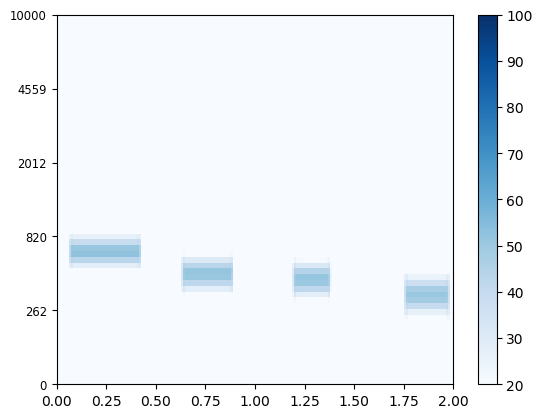

PyObject <matplotlib.colorbar.Colorbar object at 0x167386128>

In [6]:
 plot_gtg(scene_gram, scene_duration, audio_sr, 20.0, 100.0)

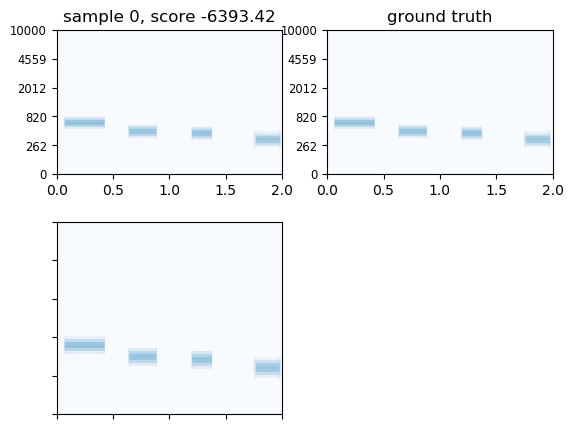

In [7]:
plot_sources(trace, scene_gram, 0; save=false)

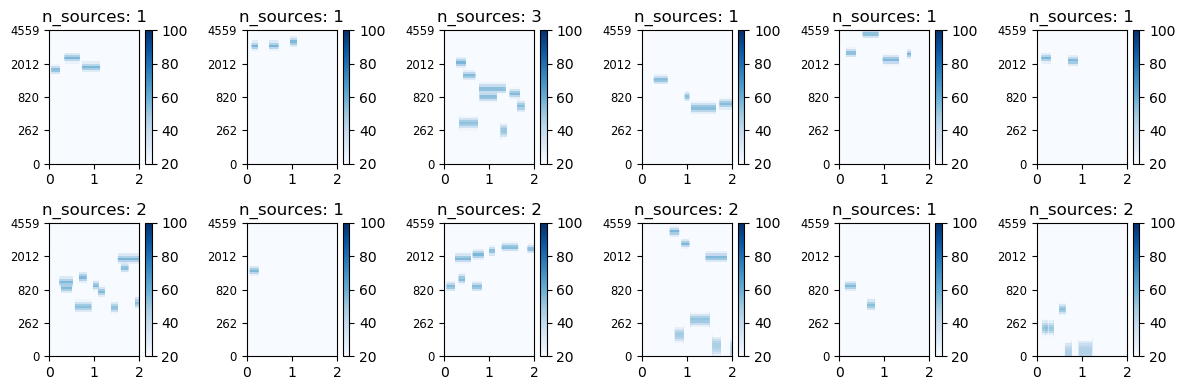

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[8]:8
└ @ Core ./In[8]:8


In [8]:
figure(figsize=(12, 4))
for i=1:12
    subplot(2, 6, i)
    trace = simulate(generate_scene, args)
    scene_gram, scene_wave, source_waves = get_retval(trace);
    n_sources = trace[:n_sources]
    ax = gca()
    ax[:set_title]("n_sources: $n_sources")
    plot_gtg(scene_gram, scene_duration, audio_sr, 20.0, 100.0)
end
tight_layout()

# MCMC

### Inference for tone level variables

Let's start with the simplest adjustments to the tones. For those, we can change the gap, duration, and frequency. 
 
We sampled our tones sequentially in order to make sure they came one after another. However, we'd rather not shift an entire set of tones if we're trying to change the timing of just a single tone.

So, first we'll write a function to retrieve the "absolute timings" of each tone (i.e. onset and offset) from the relative timings (gap and duration)

In [48]:
function absolute_timing(source_choices)
    #= Get a list of onset/offset pairs for a source =#

    n_tones = source_choices[:n_tones];
    total_time = 0; t = []
    for i = 1:n_tones
        onset = total_time + source_choices[(:tone, i) => :gap]
        duration = source_choices[(:tone, i) => :duration] 
        offset = onset + duration
        push!(t, [onset, offset])
        total_time += source_choices[(:tone, i) => :gap] + source_choices[(:tone, i) => :duration] 
    end
    return t
    
end
absolute_timing(get_submap(get_choices(trace),:source=>1))

2-element Array{Any,1}:
 [0.0856843, 0.556943]
 [0.730471, 1.06765]  

Because our model contains `gap` and `duration` but we want to propose to `onset` and `offset`, we need a new MCMC type that we haven't seen before: the involution.

The involution allows you to sample randomness **by sampling different variables, with different addresses** than the variables currently in the `trace`, and then deterministically make an assignment to the model trace addresses, to make a `new_trace`. 

The involution is especially useful for proposals that change the dimensionality of the trace, as we'll see.

There are two parts of writing an involution proposal. The first is a generative **randomness function** where you sample the randomness that is necessary for your proposal. The second is a deterministic **involution function** where you transform the proposed random variables into the model trace addresses to make a `new_trace`. In addition, you need to define what the traced values in the **randomness function** would be, if you were using it to go from `new_trace` to `trace`?

In [49]:
@gen function onset_randomness(trace, source_idx::Int, tone_idx::Int)
    
    source_choices = get_submap(get_choices(trace),:source=>source_idx)
    abs_t = absolute_timing(source_choices)
    
    old_gap = trace[:source => source_idx => (:tone, tone_idx) => :gap]
    old_duration = trace[:source => source_idx => (:tone, tone_idx) => :duration]
    
    last_offset = tone_idx == 1 ? 0 : abs_t[tone_idx-1][2]
    this_offset = abs_t[tone_idx][2]
    
    new_gap = @trace(uniform(0, old_gap + old_duration - 0.050), :proposed_gap)
    new_duration = old_duration + (old_gap - new_gap) 
    
    return old_gap, old_duration, new_gap, new_duration
    
end

function onset_involution(trace, fwd_choices, fwd_ret, proposal_args)

    source_idx, tone_idx = proposal_args
    old_gap, old_duration, new_gap, new_duration = fwd_ret
    
    bwd_choices = choicemap()
    bwd_choices[:proposed_gap] = old_gap
    
    new_choices = choicemap()
    new_choices[:source => source_idx => (:tone, tone_idx)=>:gap] = new_gap
    new_choices[:source => source_idx => (:tone, tone_idx)=>:duration] = new_duration
    
    new_trace, weight = update(trace, get_args(trace), (), new_choices)
    return new_trace, bwd_choices, weight
    
end

onset_involution (generic function with 1 method)

To look at what the onset involution proposal does, we'll pull apart the "behind-the-scenes" involution code:

In [50]:
function run_involution(randomness, involution, randomness_args, init_trace; print_choices=false)

    (fwd_choices, fwd_score, fwd_ret) = propose(randomness, (init_trace, randomness_args...))
    (new_trace, bwd_choices, weight) = involution(init_trace, fwd_choices, fwd_ret, randomness_args)
    (bwd_score, _) = assess(randomness, (new_trace,randomness_args...), bwd_choices)
    a = weight - fwd_score + bwd_score
    println("Weight: $(weight) - Fwd: $(fwd_score) + Bwd: $(bwd_score) = $a")
    if print_choices
        println("Forward choices:")
        println(fwd_choices)
        println("Backward choices")
        println(bwd_choices)
    end
    return fwd_choices, bwd_choices, new_trace

end

run_involution (generic function with 1 method)

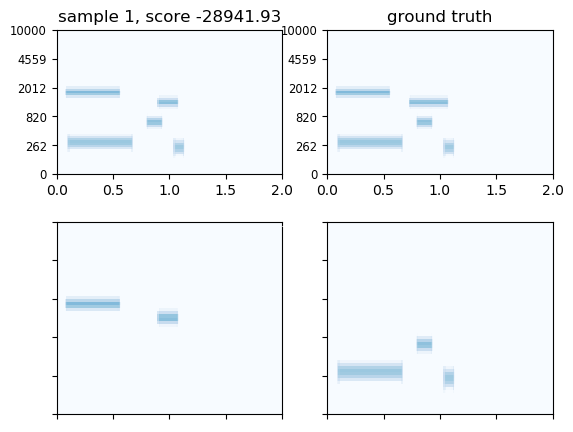

Weight: -22610.15624859406 - Fwd: 0.7749984023522138 + Bwd: 0.7749984023522138 = -22610.15624859406
Forward choices:
│
└── :proposed_gap : 0.33510651890486726

Backward choices
│
└── :proposed_gap : 0.17352859736337173



In [51]:
# plot_sources(trace, scene_gram, 0; save=false)
fwd_choices, bwd_choices, new_trace = run_involution(onset_randomness, onset_involution, (1,2,), trace; print_choices=true)
plot_sources(new_trace, scene_gram, 1; save=false)

In [52]:
@gen function duration_randomness(trace, source_idx::Int, tone_idx::Int)
    
    scene_duration, audio_sr, wts, gtg_params = get_args(trace)
    
    source_choices = get_submap(get_choices(trace),:source=>source_idx)
    n_tones = source_choices[:n_tones]
    abs_t = absolute_timing(source_choices)
    
    old_duration = trace[:source => source_idx => (:tone, tone_idx)=>:duration]
    
    if tone_idx == n_tones
        
        new_duration = @trace(dur_dist(2,0.1,0.050), :proposed_duration)
    
        return false, old_duration, false, new_duration
    
    else
    
        old_gap = trace[:source => source_idx => (:tone, tone_idx + 1) => :gap]
        next_onset = abs_t[tone_idx + 1][1]
        this_onset = abs_t[tone_idx][1]
        new_duration = @trace(uniform(0.050, next_onset - this_onset), :proposed_duration)
        new_gap = old_gap + (old_duration - new_duration)
        
        return old_gap, old_duration, new_gap, new_duration 
        
    end
    
end

function duration_involution(trace, fwd_choices, fwd_ret, proposal_args)
    
    source_idx, tone_idx = proposal_args
    old_gap, old_duration, new_gap, new_duration = fwd_ret
    
    bwd_choices = choicemap()
    new_choices = choicemap()
    if old_gap == false 
    
        bwd_choices[:proposed_duration] = old_duration
        new_choices[:source => source_idx => (:tone, tone_idx) => :duration] = new_duration
        
    else
        
        bwd_choices[:proposed_duration] = old_duration

        new_choices[:source => source_idx => (:tone, tone_idx + 1) => :gap] = new_gap
        new_choices[:source => source_idx => (:tone, tone_idx) => :duration] = new_duration
        
    end
    
    new_trace, weight = update(trace, get_args(trace), (), new_choices)
    return new_trace, bwd_choices, weight
    
end

duration_involution (generic function with 1 method)

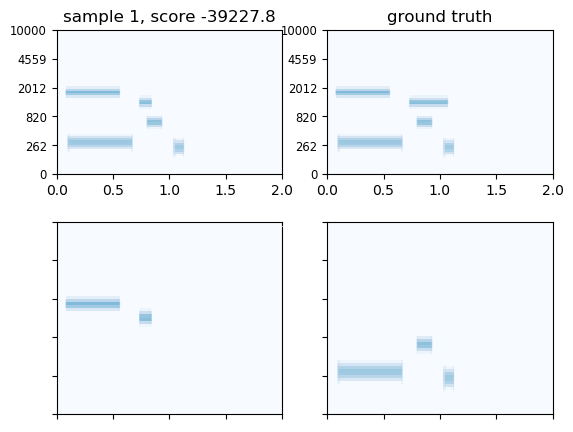

Weight: -32896.02404888819 - Fwd: 1.147744634569149 + Bwd: 0.485750698748876 = -32896.68604282401
Forward choices:
│
└── :proposed_duration : 0.10415847578769011

Backward choices
│
└── :proposed_duration : 0.33717591967855787



In [53]:
# plot_sources(trace, scene_gram, 0; save=false)
fwd_choices, bwd_choices, new_trace = run_involution(duration_randomness, duration_involution, (1,2,), trace; print_choices=true)
plot_sources(new_trace, scene_gram, 1; save=false)

For the frequency of a tone, we'll write a Gaussian Drift proposal. We can alternate this with the proposal that we resample from the prior. 

In [54]:
@gen function tonefreq_gaussian_drift(trace, source_idx::Int, tone_idx::Int)
    f = trace[:source => source_idx => (:tone, tone_idx) => :f0]
    @trace(normal(f, 1.0), :source => source_idx => (:tone, tone_idx) => :f0)
end;

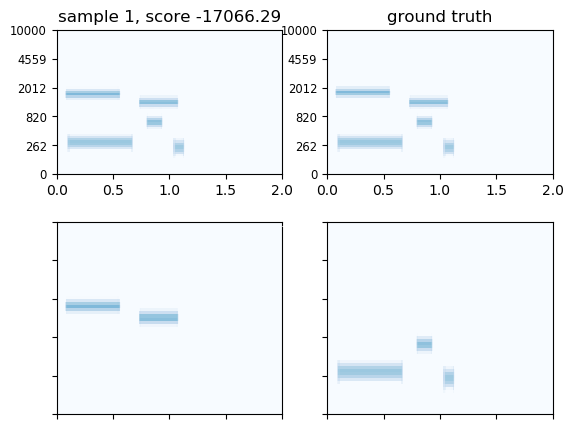

In [55]:
(proposal_choices, _, _) = propose(tonefreq_gaussian_drift, (trace, 1, 1,))
(new_trace, _, _, _) = update(trace, args, (),proposal_choices)
plot_sources(new_trace, scene_gram, 1; save=false)

### Inference for source level variables

We can similarly write a drift proposal for the mean frequency of a source

In [56]:
@gen function mu_gaussian_drift(trace, source_idx::Int)
    scene_duration, audio_sr, wts, gtg_params = get_args(trace)
    f = trace[:source => source_idx => :mu]
    @trace(truncated_normal(f, 4., freq_to_ERB(20.0), freq_to_ERB(audio_sr)), 
        :source => source_idx => :mu)
end;

For changing the number of tones in a source, we also have to write an involution move. This is because we need to randomly sample a tone to delete, or where to add one. This is not solely a source level inference move because we need to also choose the tone-level variables of the new tone that is added.

In [57]:
@gen function ntones_randomness(trace, source_idx::Int)

    source_choices = get_submap(get_choices(trace),:source=>source_idx)
    n_tones = source_choices[:n_tones]
    
    #we'll never get rid of a source by getting rid of a tone
    p = n_tones == 1 ? 1.0 : 0.5
    add_tone = @trace(bernoulli(p),:add_tone)
    
    if add_tone
        
        #since we have a minimum value for the duration of a tone,
        #find a gap in the sequence where the tone can fit 
        enough_space = [source_choices[(:tone, i) => :gap] > 0.050 for i = 1:n_tones]
        #add an extra possibility to add a tone onto the end
        push!(enough_space, true)
        enough_space = Int.(enough_space)
        enough_space = enough_space ./ sum(enough_space)
        
        #sample the index of the tone that will be added
        add_idx = @trace(categorical(enough_space), :add_idx)
        
        if add_idx <= n_tones
            old_gap = source_choices[(:tone,add_idx)=>:gap]
            add_duration = @trace(uniform(0.050, old_gap), :add_duration)
            add_gap = @trace(uniform(0, old_gap-add_duration), :add_gap)
        elseif add_idx == n_tones + 1
            add_gap = @trace(gamma(2,0.1), :add_gap)
            add_duration = @trace(dur_dist(2,0.1,0.050), :add_duration)
        end
        add_frequency = @trace(normal(source_choices[:mu], 3.0), :add_frequency)
        
    else #delete tone
        
        delete_idx = @trace(uniform_discrete(1,n_tones), :delete_idx)
        
    end
    
    return add_tone
    
end

function ntones_involution(trace, fwd_choices, fwd_ret, proposal_args)
        
    source_idx, = proposal_args
    add_tone = fwd_ret
    old_choices = get_submap(get_choices(trace),:source => source_idx)
    abs_t = absolute_timing(old_choices)
    
    bwd_choices = choicemap()
    new_choices = choicemap()  
    bwd_choices[:add_tone] = ~add_tone
    
    if add_tone
        
        ##Add_element
        new_choices[:source => source_idx => :n_tones] = old_choices[:n_tones] + 1

        #Add in new timing info 
        add_idx = fwd_choices[:add_idx]
        new_choices[:source => source_idx => (:tone, add_idx) => :gap] = fwd_choices[:add_gap]
        new_choices[:source => source_idx => (:tone, add_idx) => :duration] = fwd_choices[:add_duration]
        new_choices[:source => source_idx => (:tone, add_idx) => :f0] = fwd_choices[:add_frequency]
         
        #If there are any elements after the added element: 
        if add_idx != old_choices[:n_tones] + 1
            #Need to change the "gap" of the tone immediately after the add_element, in order to retain the same onset
            new_choices[:source => source_idx => (:tone, add_idx + 1) => :gap] = old_choices[(:tone, add_idx) => :gap] - fwd_choices[:add_gap] - fwd_choices[:add_duration]
            new_choices[:source => source_idx => (:tone, add_idx +1) => :duration] = old_choices[(:tone, add_idx) => :duration]
            new_choices[:source => source_idx => (:tone, add_idx + 1) => :f0] = old_choices[(:tone, add_idx) => :f0]

            #All elements after (the element immediately following the add_telement) are simply shifted in index
            old_idxs = add_idx + 1 == old_choices[:n_tones] + 1 ? [] : add_idx+1:old_choices[:n_tones]
            for old_tone_idx = old_idxs
                set_submap!(new_choices, :source => source_idx => (:tone, old_tone_idx + 1), get_submap(old_choices,(:tone, old_tone_idx)))
            end
            
        end
                                                            
        bwd_choices[:delete_idx] = add_idx
        
        
    else
        
        new_choices[:source => source_idx => :n_tones] = old_choices[:n_tones] - 1
        delete_idx = fwd_choices[:delete_idx]
        
        #If the deleted tone is in the middle of a sequence:
        if delete_idx < old_choices[:n_tones]
            #Adjust the wait time of the element following the one that was removed
            last_offset = delete_idx > 1 ? abs_t[delete_idx - 1][2] : 0
            new_choices[:source => source_idx => (:tone, delete_idx) => :gap] = abs_t[delete_idx+1][1] - last_offset
            new_choices[:source => source_idx => (:tone, delete_idx) => :duration] = old_choices[(:tone, delete_idx + 1) => :duration]
            new_choices[:source => source_idx => (:tone, delete_idx) => :f0] = old_choices[(:tone, delete_idx + 1) => :f0]
        
            #All the elements after the one immediately following the deleted element must shift their indices 
            old_idxs = delete_idx == old_choices[:n_tones] - 1 ? [] : (delete_idx + 2):old_choices[:n_tones]
            for old_tone_idx = old_idxs  
                set_submap!(new_choices, :source => source_idx => (:tone, old_tone_idx-1), get_submap(old_choices,(:tone, old_tone_idx)))
            end
        end
                
        #Define backwards choice by putting remove_elementback in                                                                
        bwd_choices[:add_idx] = delete_idx        
        bwd_choices[:add_gap] = old_choices[(:tone, delete_idx) => :gap]  
        bwd_choices[:add_duration] = old_choices[(:tone, delete_idx) => :duration] 
        bwd_choices[:add_frequency] = old_choices[(:tone, delete_idx) => :f0]   
        
    end
    
    new_trace, weight = update(trace, get_args(trace), (), new_choices)
    return new_trace, bwd_choices, weight
    
end

ntones_involution (generic function with 1 method)

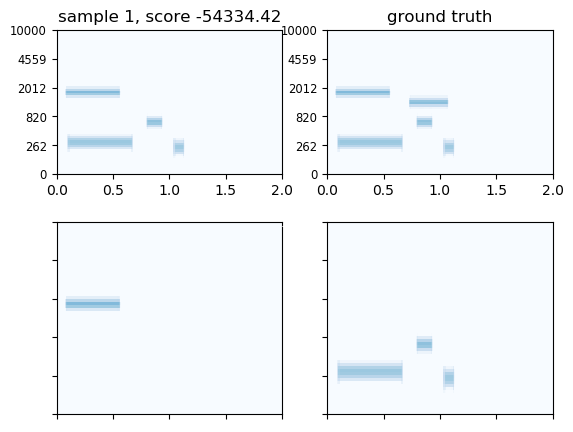

Weight: -48002.6525398236 - Fwd: -1.3862943611198906 + Bwd: -1.1195367468473947 = -48002.38578220933


In [58]:
# plot_sources(trace, scene_gram, 0; save=false)
fwd_choices, bwd_choices, new_trace = run_involution(ntones_randomness, ntones_involution, (1,), trace; print_choices=false)
plot_sources(new_trace, scene_gram, 1; save=false)

## "Switch move"

In [86]:
@gen function switch_randomness(trace)
    
    scene_duration, audio_sr, wts, gtg_params = get_args(trace)
    old_choices = get_choices(trace)
    
    #onset/offset information for each element in each source: all source timings
    all_source_timings = []
    old_n_sources = old_choices[:n_sources]
    for i = 1:old_n_sources
        #list of lists of times
        #[ (element 1)[onset, offset], (element2)[onset, offset], ... ]
        old_abs_timings = absolute_timing(get_submap(old_choices, :source => i))
        push!(all_source_timings,old_abs_timings) 
    end
    
    origin = @trace(uniform_discrete(1, old_n_sources), :origin)
    old_n_elements = old_choices[:source => origin => :n_tones]
    element_idx = @trace(uniform_discrete(1,old_n_elements),:element_idx)
    onset = all_source_timings[origin][element_idx][1];
    offset = all_source_timings[origin][element_idx][2];
    
    #Find the sources into which a element can be switched 
    source_switch = []; which_spot = [];
    for i = 1:old_choices[:n_sources]
        if i == origin 
            append!(source_switch, 0); append!(which_spot, 0)
        else
            source_nt = old_choices[:source => i => :n_tones]
            timings = all_source_timings[i];
            for j = 1:source_nt + 1

                #switch into spot before the first element
                if j == 1 
                    fits = (0 < onset) && (offset < timings[j][1])
                elseif 1 < j <= source_nt
                    fits = (timings[j-1][2] < onset) && (offset < timings[j][1])
                elseif j == source_nt + 1
                    fits = (timings[j - 1][2] < onset)
                end

                if fits
                    append!(source_switch, 1)
                    append!(which_spot, j)
                    break
                elseif j == source_nt + 1
                    append!(source_switch, 0)
                    append!(which_spot, 0)
                end

            end
        end
    end
    
    #Decide whether to move the element into an existing source
    #Or make a new source, where it will be the only element
    switch_to_existing_source = sum(source_switch)
    switch_to_new_source = old_n_elements > 1 ? 1 : 0     
    switch_weights = [switch_to_existing_source, switch_to_new_source]
    if sum(switch_weights) == 0
        return "abort"
    end
    switch_weights = [switch_to_existing_source, switch_to_new_source]

    ps = switch_weights./sum(switch_weights)
    new_source = @trace(bernoulli(ps[2]), :new_source)
    #Decide the idx of the destination source
    #If it's a new source, it can go before any of the old sources or at the end
    #If it's an old source, you need to choose from the ones in source_switch
    destination_ps = new_source ? fill(1/(old_choices[:n_sources] + 1), old_choices[:n_sources] + 1) : source_switch./sum(source_switch)
    destination = @trace(categorical(destination_ps), :destination)
    
    ## change the means of the sources, so that there's the best possibility for acceptance
    if ~new_source                                                                                            
        dest_f0s = [trace[:source => destination => (:tone, j) => :f0] for j = 1:old_choices[:source => destination => :n_tones]]
    else
        dest_f0s = []
    end
    push!(dest_f0s, old_choices[:source => origin => (:tone, element_idx) => :f0])
    m = mean(dest_f0s); s = length(dest_f0s) > 1 ? std(dest_f0s) : 3.0; l = freq_to_ERB(20.0); u = freq_to_ERB(audio_sr/2.);
    @trace(truncated_normal(m, s, l, u), :dest => :mu)                                                                                                               
                                                                                                                    
    if old_choices[:source => origin => :n_tones] > 1  
        orig_f0s = [trace[:source => origin => (:tone, j) => :f0] for j in 1:trace[:source => origin => :n_tones] if j != element_idx]
        m = mean(orig_f0s); s = length(orig_f0s) > 1 ? std(orig_f0s) : 3.0; 
        @trace(truncated_normal(m, s, l, u), :orig => :mu) 
    end 
                                                                                                                                                                                                                                      
    return which_spot, all_source_timings
               
end                                                                                                                                    
                                                    
function switch_involution(trace, fwd_choices, fwd_ret, proposal_args)
    
    if fwd_ret == "abort"
        return trace, fwd_choices, 0
    end
                    
    #we need to specify how to go backwards
    #and how to construct the new trace
    bwd_choices = choicemap()
    new_choices = choicemap()
    which_gaps = fwd_ret[1]; all_source_timings = fwd_ret[2];
    
    scene_duration, audio_sr, wts, gtg_params = get_args(trace)
    old_choices = get_choices(trace); 
    old_n_sources = old_choices[:n_sources]; 
    
    ## indexes for moving a element from origin to destination source
    origin_idx = fwd_choices[:origin]
    new_source = fwd_choices[:new_source]
    destination_idx = fwd_choices[:destination]
    element_switch_idx = fwd_choices[:element_idx]
                                                                                                                             
    old_origin_nt = old_choices[:source => origin_idx => :n_tones]
    old_destination_nt = new_source ? 0 : old_choices[:source => destination_idx => :n_tones]
    which_gap = new_source ? 1 : which_gaps[destination_idx]
    element_attributes = [:gap, :duration, :f0]
    element_attributes_no_wait = [:duration, :f0]

    ##Get all the properties of the switch element in the new source
    switch_element = Dict()
    #absolute onset and offset stay the same, so do duration and gps
    switch_element[:onset] = all_source_timings[origin_idx][element_switch_idx][1] 
    switch_element[:offset] = all_source_timings[origin_idx][element_switch_idx][2]         
    switch_element[:duration]= old_choices[:source => origin_idx => (:tone, element_switch_idx) => :duration]
    switch_element[:f0]=old_choices[:source => origin_idx => (:tone, element_switch_idx) => :f0]
    #gap depends on what is before the switch_element in the destination stream
    prev_offset = (which_gap == 1) ? 0 : all_source_timings[destination_idx][which_gap - 1][2] 
    switch_element[:gap] = switch_element[:onset] - prev_offset;

    ##compute new GAPS OF elementS FOLLOWING SWITCH element, in both destination and origin
    #inserting switch_element before a element in destination source
    if which_gap <= old_destination_nt
        dest_after_gap = all_source_timings[destination_idx][which_gap][1] - switch_element[:offset]
    end
    #removing switch_element before a element in origin source
    if element_switch_idx < old_origin_nt
        prev_offset = element_switch_idx == 1 ? 0 : all_source_timings[origin_idx][element_switch_idx - 1][2]
        orig_after_gap = all_source_timings[origin_idx][element_switch_idx + 1][1] - prev_offset
    end
    
    if old_origin_nt == 1 
        # If the origin stream had only one element in it, it should be removed
        # The switch_element will not be moved into a new stream,
        # so n_sources should always decrease by 1
        
        # new_source = false
        # destination_idx chooses an existing source 
        
        # if destination_idx is larger than origin_idx
        # the idx of the destination source needs to be shifted down one
        # and any sources after the destination source need to be shifted down one
        
        # if destination_idx is smaller than origin_idx
        # the idx of the destination source can remain the same, 
        # but others may be shifted down one 

        new_choices[:n_sources] = old_n_sources - 1
        #Get indexes of old sources that must be changed 
        new_idx = 1:(old_n_sources - 1)
        #the OLD labels after the origin index are shifted up one because their new labels will be one smaller
        old_idx = [(n >= origin_idx ? (n + 1) : n) for n in new_idx] 
        #Only need to change old indexes that are greater than or equal to the origin idx
        #Get rid of (old_idx < origin_idx) because those won't change...
        #...as well as the destination index, which will be treated on its own
        matching_new_idx = [new_idx[i] for i in 1:length(new_idx) if (old_idx[i] != destination_idx)]
        old_idx = [o for o in old_idx if (o != destination_idx)]
        
        ##Shift sources that do not change
        for i = 1:length(old_idx)                        
            set_submap!(new_choices, :source=>matching_new_idx[i], get_submap(old_choices,:source=>old_idx[i]))                        
        end
        
        ##Deal with destination source specifically
        old_destination_idx = destination_idx
        new_destination_idx = old_destination_idx > origin_idx ? old_destination_idx - 1 : old_destination_idx 
        old_nt = old_choices[:source=>old_destination_idx=>:n_tones]
                                                
        #Get source attributes
        new_choices[:source => new_destination_idx => :n_tones] = old_nt + 1
        new_choices[:source => new_destination_idx => :mu] = fwd_choices[:dest => :mu]

        #Switch element
        for a in element_attributes
            new_choices[:source => new_destination_idx => (:tone, which_gap) => a] = switch_element[a]
        end
                                
        #All elements before the switch_element stay the same
        if which_gap > 1
            for j = 1:which_gap - 1
                set_submap!(new_choices, :source => new_destination_idx => (:tone, j), get_submap(old_choices,:source=>old_destination_idx=>(:tone,j)))
            end
        end
        #If there are any elements after the switch_element they must be increased in index by one
        if which_gap <= old_nt #comes before one of the old elements
            for new_element_idx = (which_gap + 1):(old_nt + 1)
                new_choices[:source => new_destination_idx => (:tone, new_element_idx) => :gap] = (new_element_idx == (which_gap + 1)) ? dest_after_gap : old_choices[:source => old_destination_idx => (:tone,new_element_idx-1) => :gap]
                for a in element_attributes_no_wait
                    new_choices[:source => new_destination_idx => (:tone, new_element_idx) => a] = old_choices[:source=>old_destination_idx=>(:tone,new_element_idx-1)=>a]
                end 
            end
        end

        bwd_choices[:origin] = new_destination_idx
        bwd_choices[:new_source] = true

        bwd_choices[:dest => :mu] = old_choices[:source => origin_idx => :mu]
        bwd_choices[:orig => :mu] = old_choices[:source => destination_idx => :mu]

        bwd_choices[:destination] = origin_idx
        bwd_choices[:element_idx] = which_gap
            
    elseif new_source
        # we put the element in a new stream 
        # we keep the origin stream as well
        # so n_sources increases by 1
        # need to shift all the sources after the destination_idx
                                
        new_choices[:n_sources] = old_n_sources + 1
        
        ##Create new destination source with a single element in it
        new_choices[:source => destination_idx => :n_tones] = 1
        new_choices[:source => destination_idx => :mu] = fwd_choices[:dest => :mu]

        for a in element_attributes
            new_choices[:source => destination_idx => (:tone, 1) => a] = switch_element[a]
        end

        ##in origin source, move all elements down one index if they're after the switch index
        old_origin_idx = origin_idx
        new_origin_idx = origin_idx >= destination_idx ? origin_idx + 1 : origin_idx
        old_nt = old_choices[:source => origin_idx => :n_tones]
        new_choices[:source => new_origin_idx => :n_tones] = old_nt - 1
        new_choices[:source => new_origin_idx => :mu] = fwd_choices[:orig => :mu]

        if element_switch_idx > 1
            for j = 1:element_switch_idx - 1
                set_submap!(new_choices, :source => new_origin_idx => (:tone, j), get_submap(old_choices,:source=>old_origin_idx=>(:tone,j)))
            end
        end                        
        if element_switch_idx < old_nt
            for old_element_idx = (element_switch_idx + 1):old_nt
                new_choices[:source => new_origin_idx => (:tone, old_element_idx-1)=>:gap] = (old_element_idx == (element_switch_idx + 1)) ? orig_after_gap : old_choices[:source => origin_idx => (:tone, old_element_idx)=> :gap]
                for a in element_attributes_no_wait
                    new_choices[:source => new_origin_idx => (:tone, old_element_idx-1) => a] = old_choices[:source=>origin_idx=>(:tone,old_element_idx)=>a]
                end 
            end
        end
                                
        ##shift all sources after destination_idx up one
        if destination_idx < new_choices[:n_sources]
            shift_idxs = [i for i in (destination_idx+1):new_choices[:n_sources] if i != new_origin_idx]
            for i in shift_idxs
                set_submap!(new_choices, :source=>i, get_submap(old_choices, :source=>i-1))
            end
        end
                                
        bwd_choices[:origin] = destination_idx
        bwd_choices[:new_source] = false  

        bwd_choices[:dest => :mu] = old_choices[:source => origin_idx => :mu]

        bwd_choices[:destination] = new_origin_idx
        bwd_choices[:element_idx] = 1
            
    else
        # we put the element in an old stream, and keep the origin stream
        # streams do not have to be shifted 
        # new_source = false
        ##in origin source, move all elements to earlier index if they're after the switch index
        old_nt = old_choices[:source => origin_idx => :n_tones]
        new_choices[:source => origin_idx => :n_tones] = old_nt - 1
        new_choices[:source => origin_idx => :mu] = fwd_choices[:orig => :mu]

        if element_switch_idx < old_nt
            for old_element_idx = (element_switch_idx + 1):old_nt
                new_choices[:source => origin_idx => (:tone, old_element_idx-1)=>:gap] = (old_element_idx == (element_switch_idx + 1)) ? orig_after_gap : old_choices[:source => origin_idx => (:tone, old_element_idx)=>:gap]
                for a in element_attributes_no_wait
                    new_choices[:source => origin_idx => (:tone, old_element_idx-1) => a] = old_choices[:source=>origin_idx=>(:tone,old_element_idx)=>a]
                end 
            end
        end
            
        ##in destination source, insert element and then shift elements to later index
        old_nt = old_choices[:source => destination_idx => :n_tones]
        new_choices[:source => destination_idx => :n_tones] = old_nt + 1
        new_choices[:source => destination_idx => :mu] = fwd_choices[:dest => :mu]

        #Switch element
        for a in element_attributes
            new_choices[:source => destination_idx => (:tone, which_gap) => a] = switch_element[a]
        end
        #elements after switch_element
        if which_gap <= old_nt
            for new_element_idx = (which_gap + 1):(old_nt + 1)
                new_choices[:source => destination_idx =>(:tone,new_element_idx)=>:gap] = (new_element_idx == (which_gap + 1)) ? dest_after_gap : old_choices[:source => destination_idx => (:tone, new_element_idx-1)=> :gap]
                for a in element_attributes_no_wait
                    new_choices[:source => destination_idx => (:tone, new_element_idx) => a] = old_choices[:source=>destination_idx=>(:tone,new_element_idx-1)=>a]
                end
            end
        end
            
        bwd_choices[:origin] = destination_idx
        bwd_choices[:destination] = origin_idx
        bwd_choices[:element_idx] = which_gap
        bwd_choices[:new_source] = false

        bwd_choices[:dest => :mu] = old_choices[:source => origin_idx => :mu]
        bwd_choices[:orig => :mu] = old_choices[:source => destination_idx => :mu]

                                            
              
    end
    new_trace, weight = update(trace, get_args(trace), (), new_choices)
    return new_trace, bwd_choices, weight

end

switch_involution (generic function with 1 method)

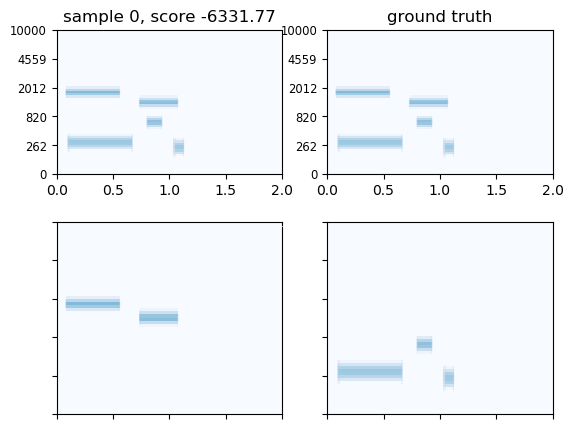

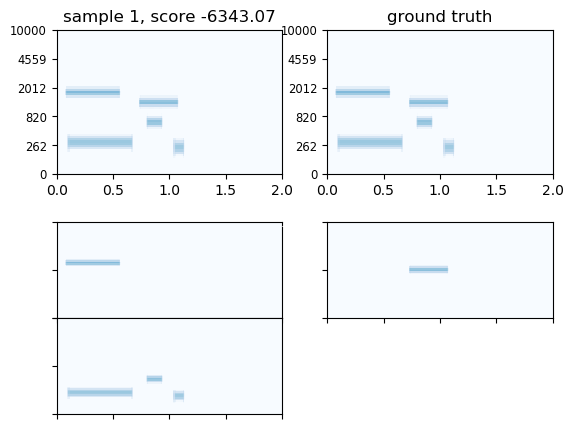

Weight: -11.293958920355092 - Fwd: -8.048174554282493 + Bwd: -2.6150273168388445 = -5.860811682911443


In [87]:
plot_sources(trace, scene_gram, 0; save=false)
fwd_choices, bwd_choices, new_trace = run_involution(switch_randomness, switch_involution, (), trace; print_choices=false)
plot_sources(new_trace, scene_gram, 1; save=false)

## Putting it all together

In [92]:
function run_proposals(initial_trace, obs_gram, n_blocks)

    trace = initial_trace
    for block_idx = 1:n_blocks
        for source_idx = 1:trace[:n_sources]
            
            n_tones = trace[:source => source_idx => :n_tones]
            for tone_idx = 1:n_tones
                trace, accepted = mh(trace, onset_randomness, (source_idx, tone_idx,), onset_involution)
                trace, accepted = mh(trace, duration_randomness, (source_idx,tone_idx,), duration_involution)
                trace, accepted = mh(trace, tonefreq_gaussian_drift, (source_idx, tone_idx,)) 
            end
            
            for rep_idx = 1:10
                trace, accepted = mh(trace, mu_gaussian_drift, (source_idx,))
                trace, accepted = mh(trace, ntones_randomness, (source_idx,), ntones_involution)
            end
            
        end
        
        for rep_idx = 1:10
            trace, accepted = mh(trace, switch_randomness, (), switch_involution)
        end
        
        for rep_idx = 1:2
            trace, accepted = mh(trace, select(:n_sources))
        end
        
        plot_sources(trace, obs_gram, block_idx; save=false)
        
    end
    
    return trace
    
end

function run_inference(obs_gram, args; n_blocks=10)
    
    constraints = choicemap((:scene, obs_gram))
    initial_trace, _ = generate(generate_scene, args, constraints)
    final_trace = run_proposals(initial_trace, obs_gram, n_blocks)
    return final_trace
    
end

run_inference (generic function with 1 method)

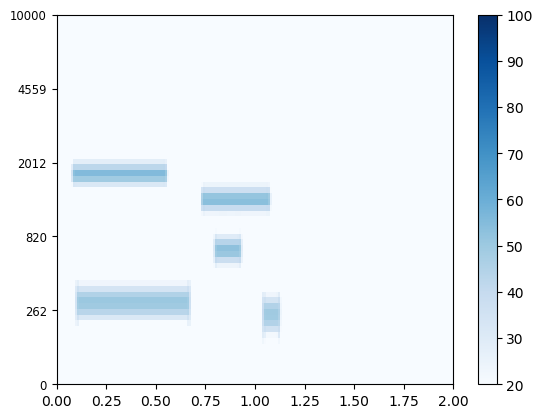

PyObject <matplotlib.colorbar.Colorbar object at 0x16a4ba860>

In [35]:
trace = simulate(generate_scene, args)
scene_gram, scene_wave, source_waves = get_retval(trace);
plot_gtg(scene_gram, scene_duration, audio_sr, 20.0, 100.0)

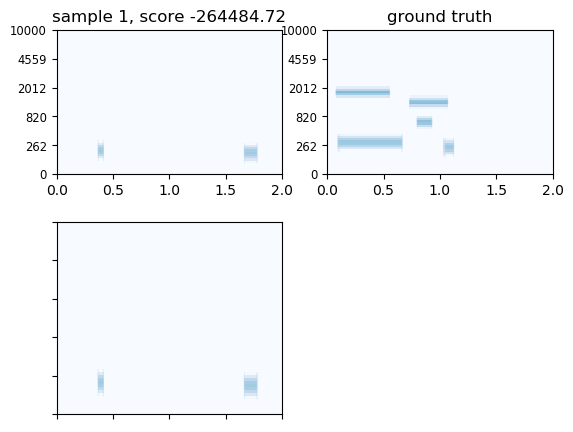

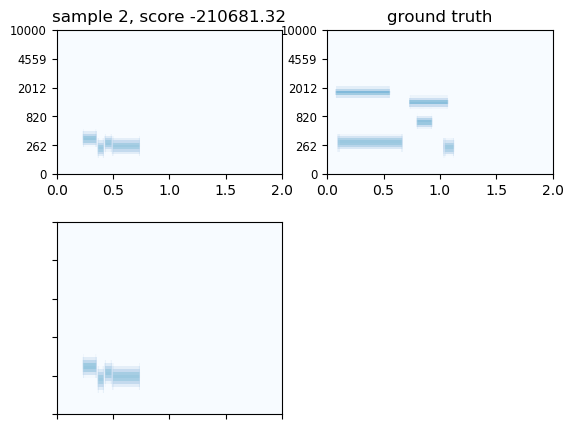

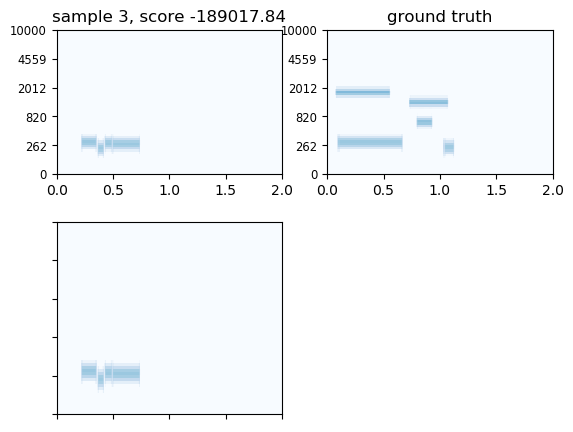

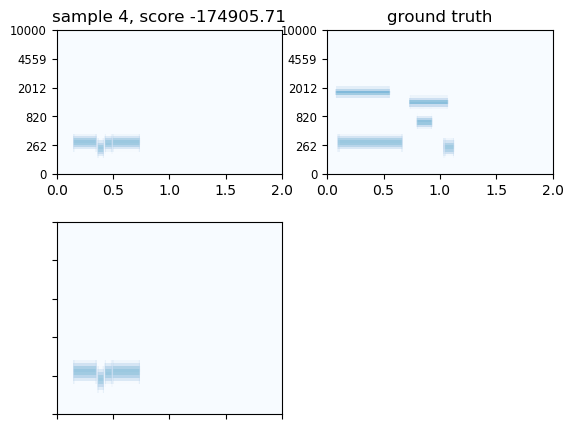

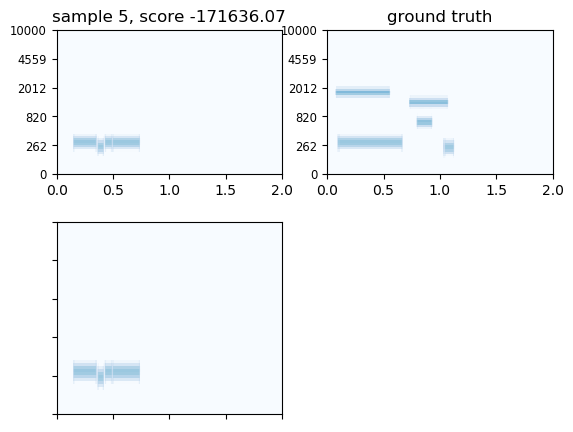

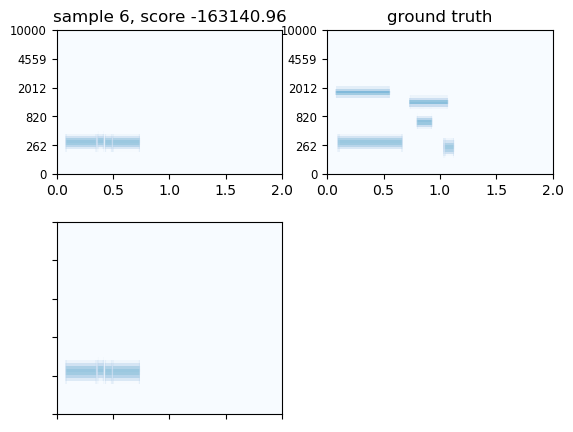

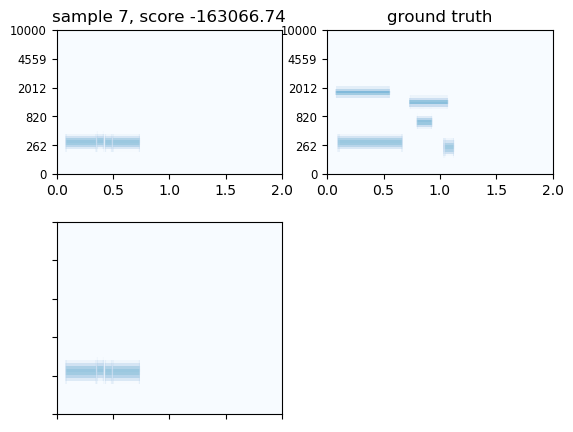

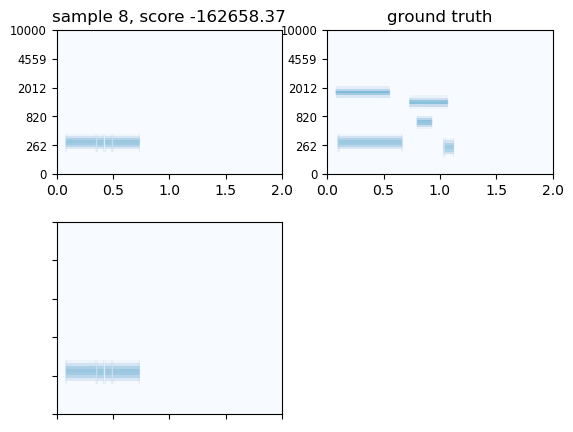

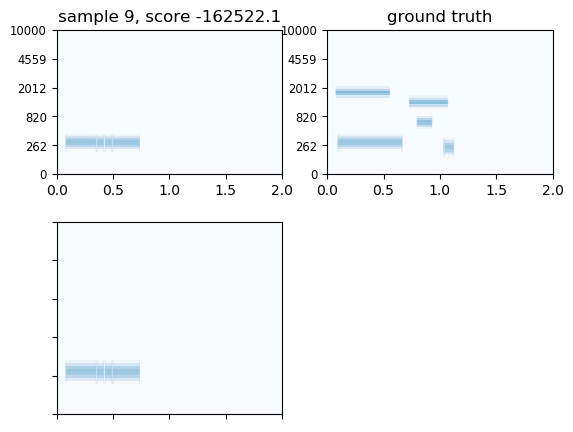

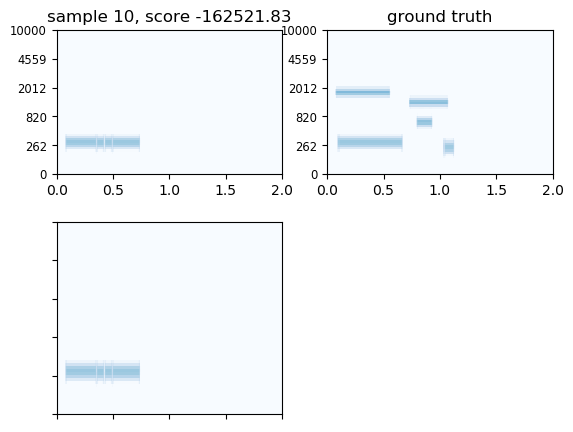

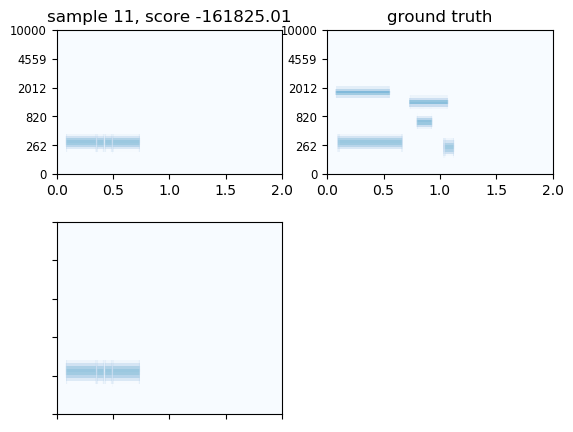

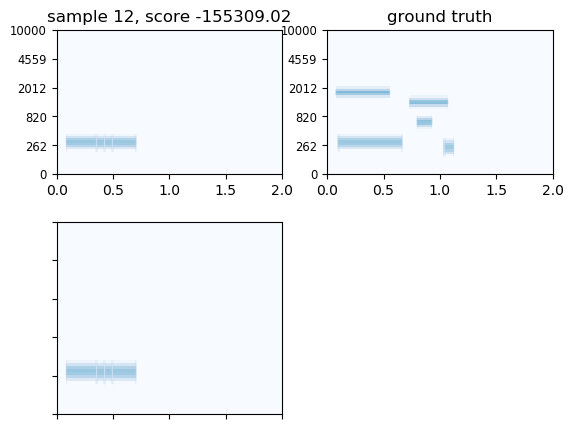

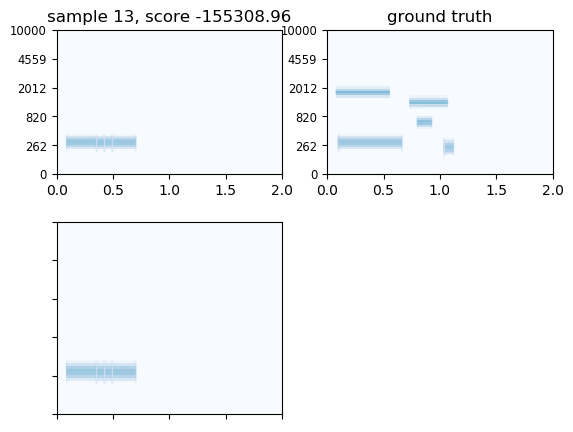

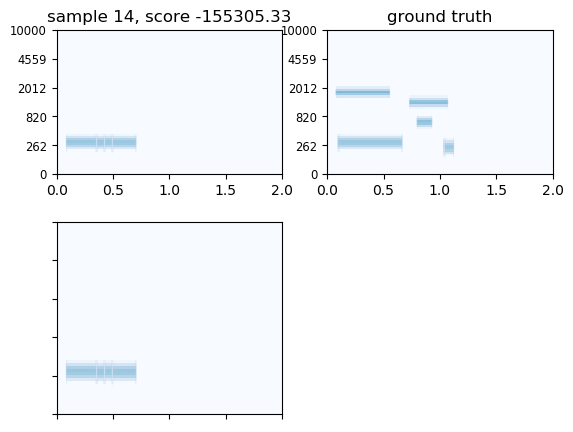

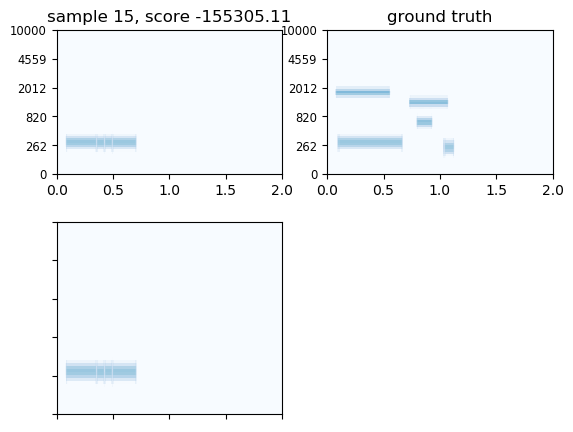

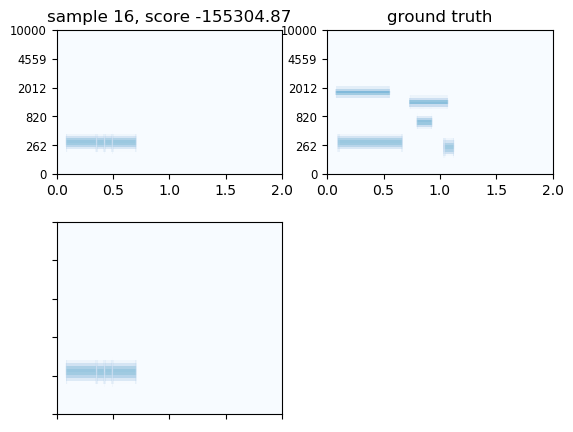

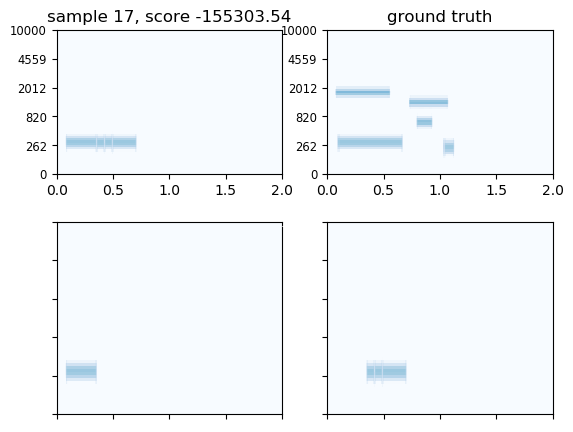

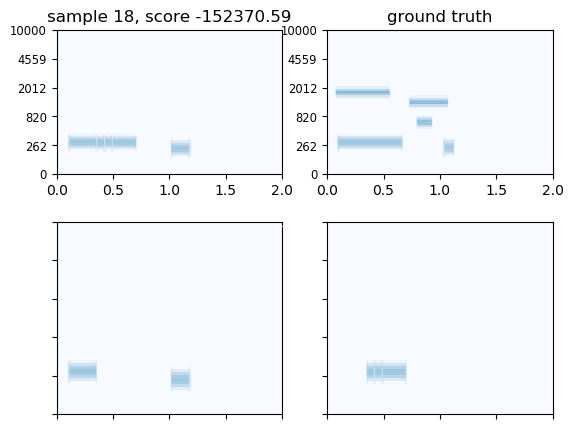

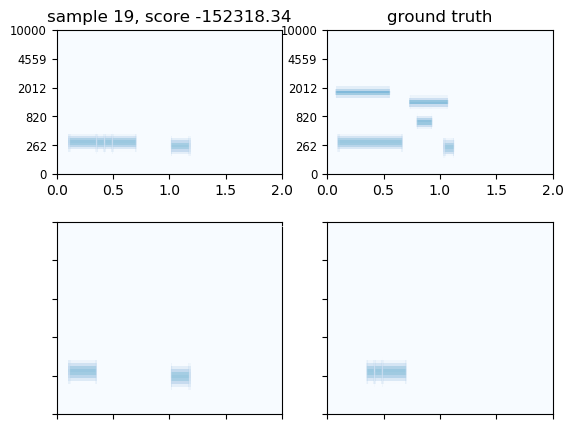

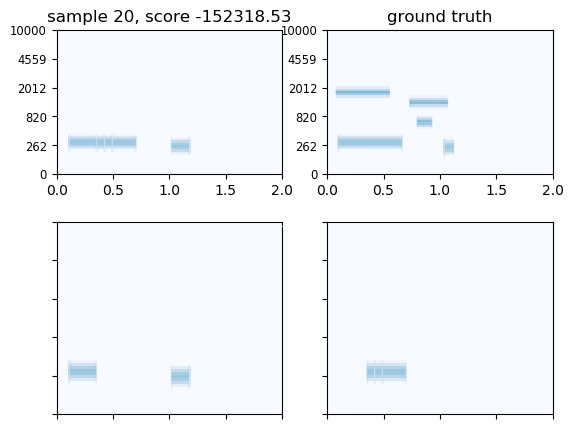

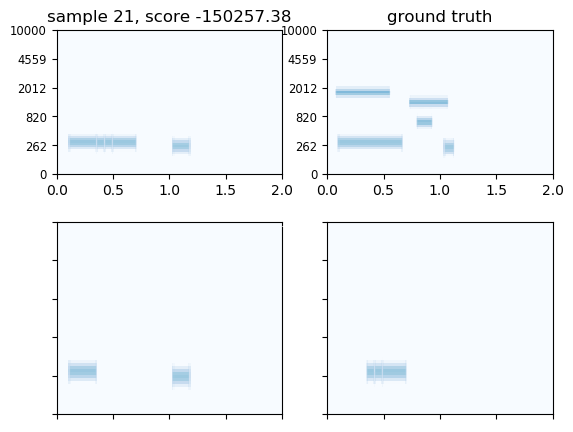

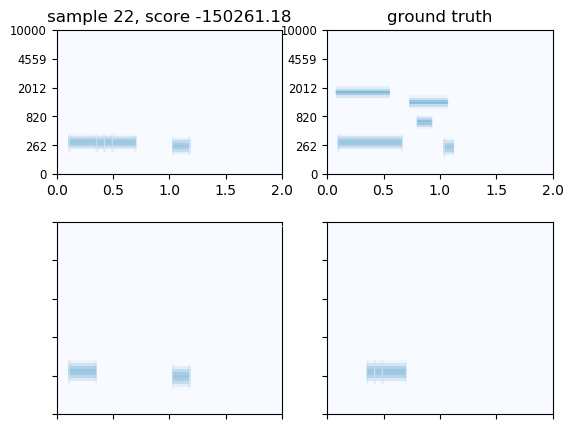

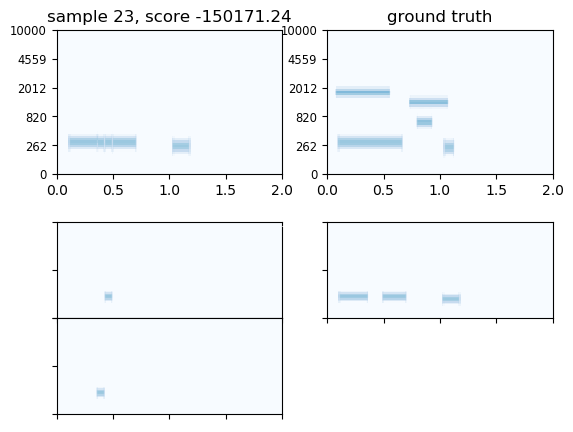

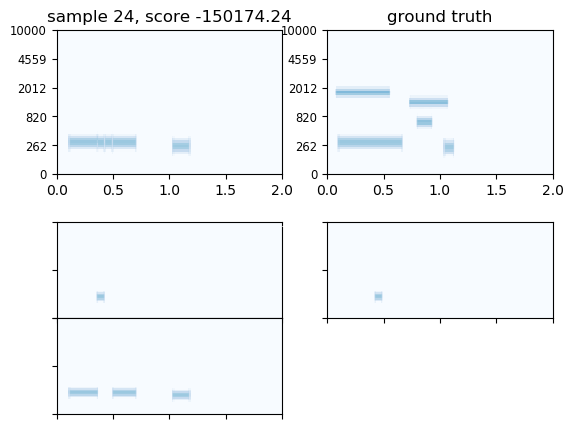

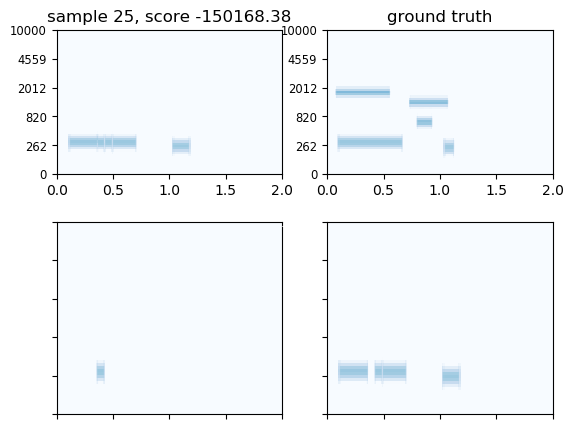

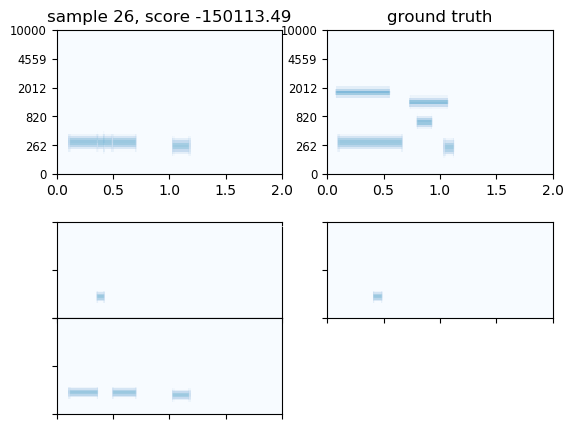

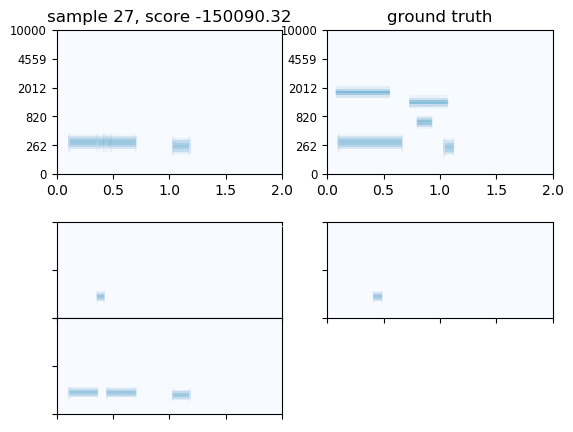

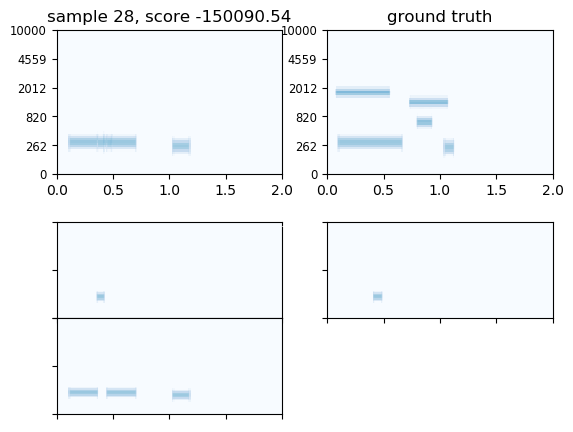

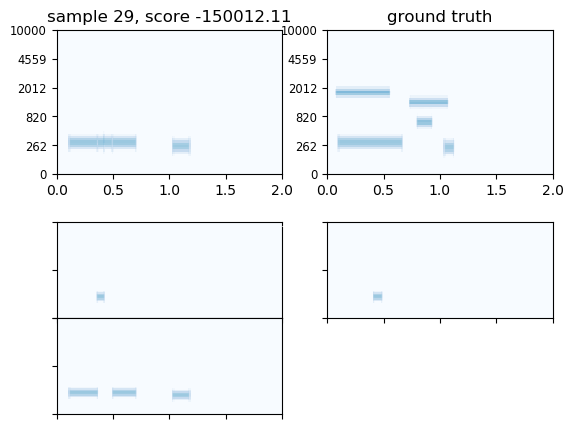

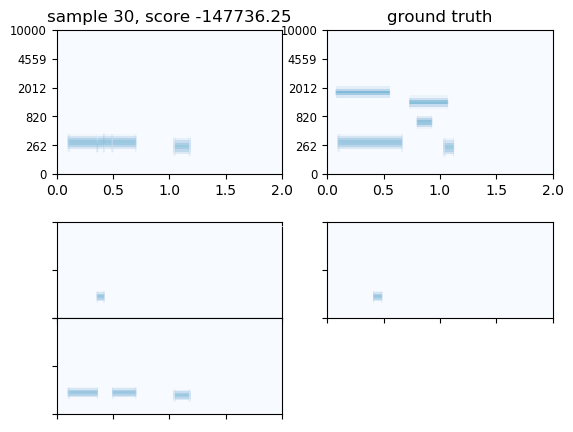

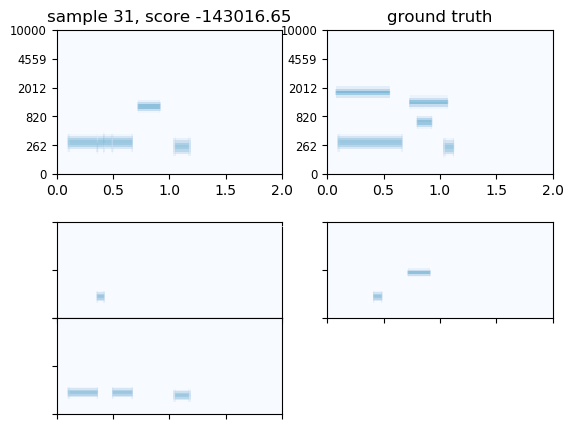

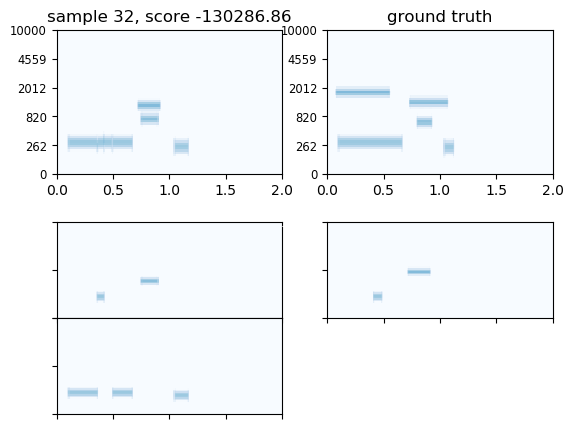

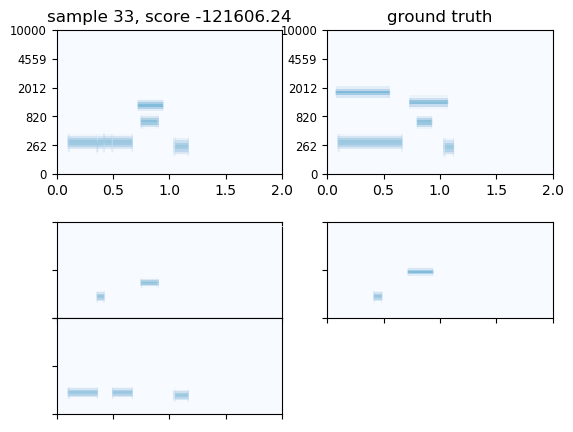

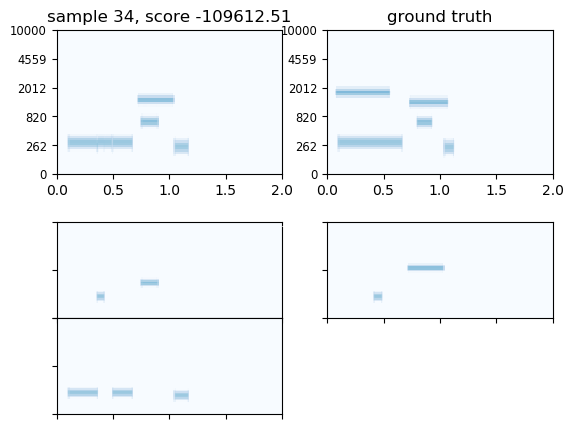

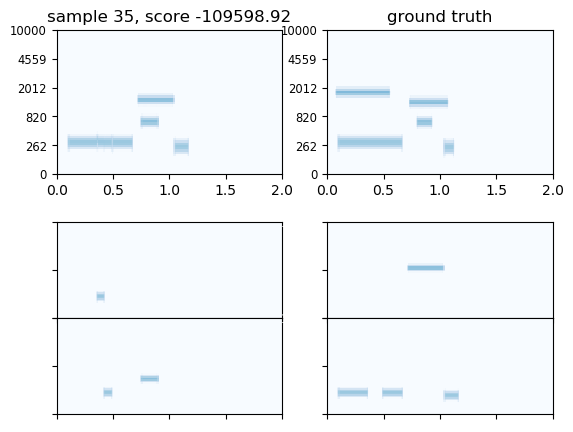

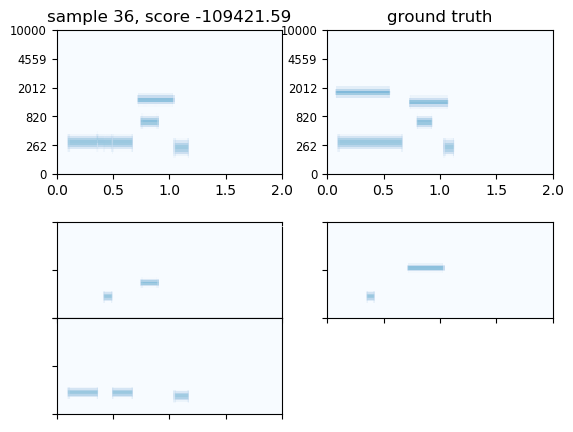

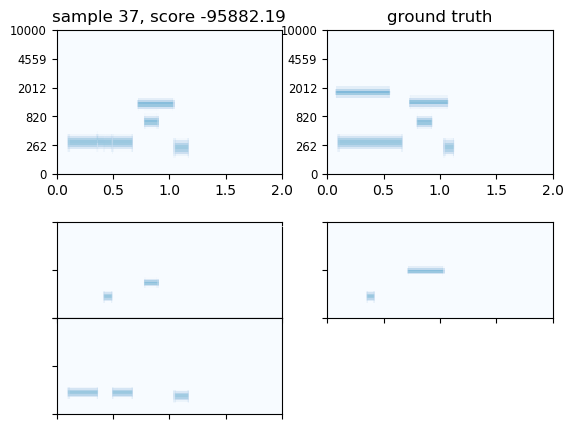

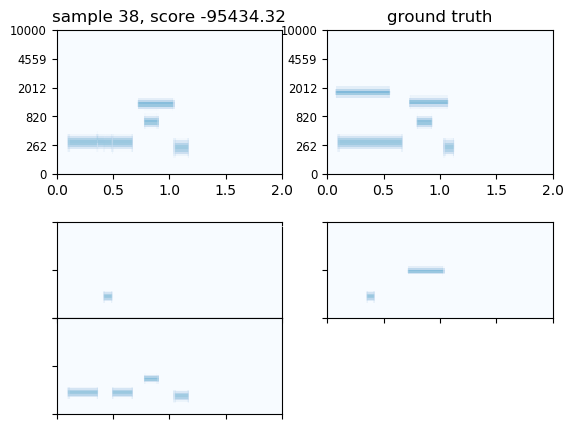

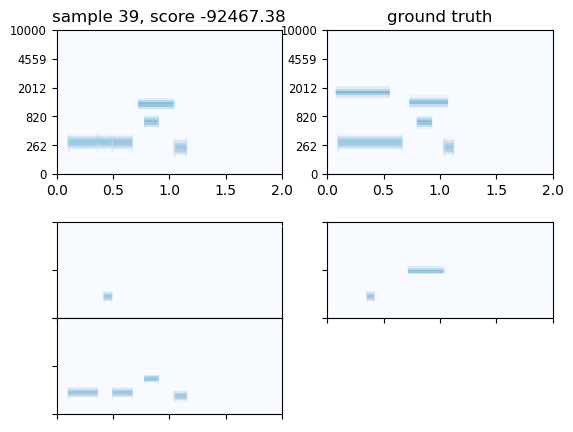

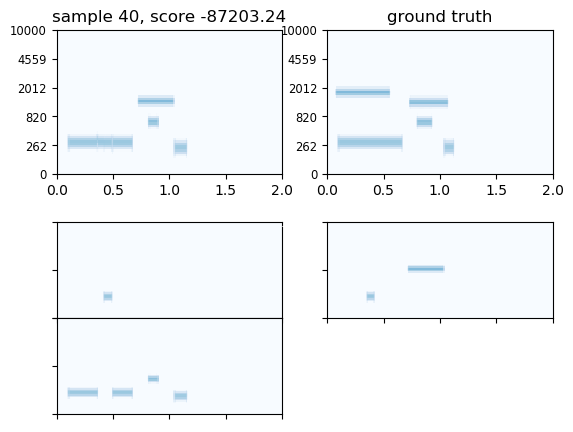

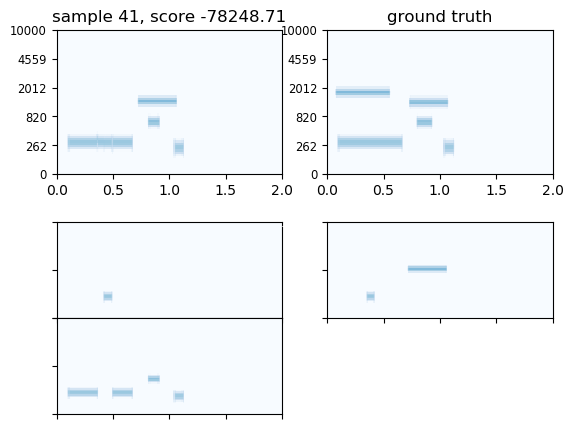

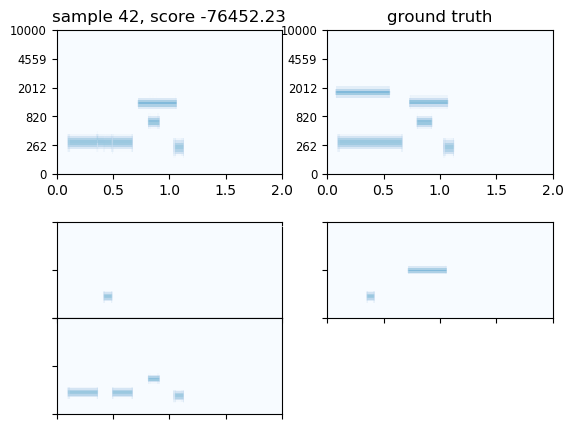

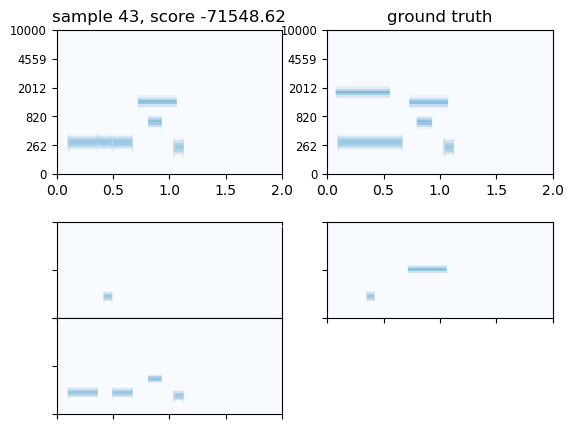

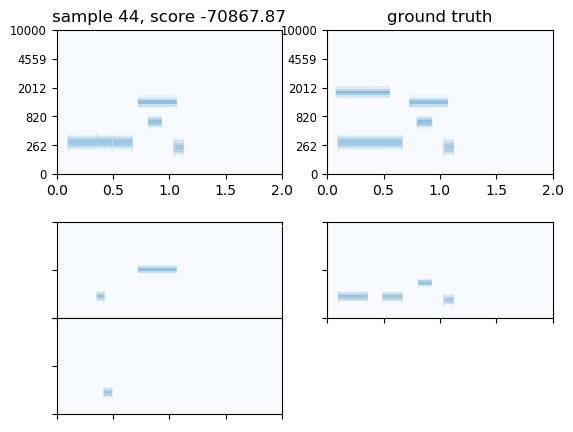

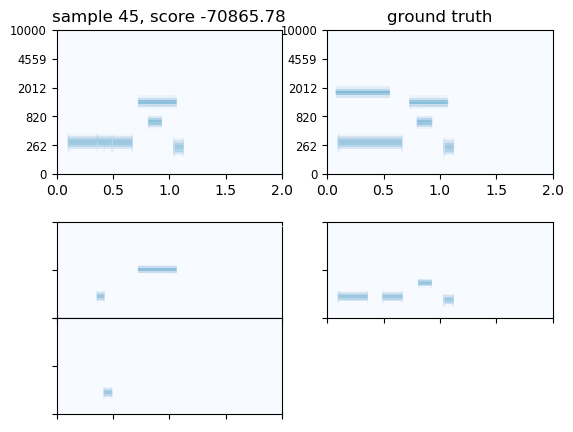

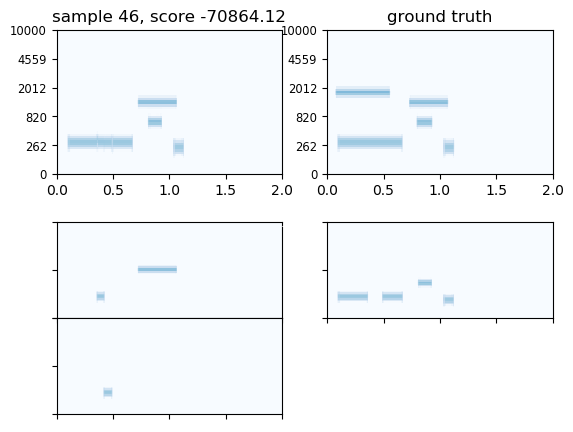

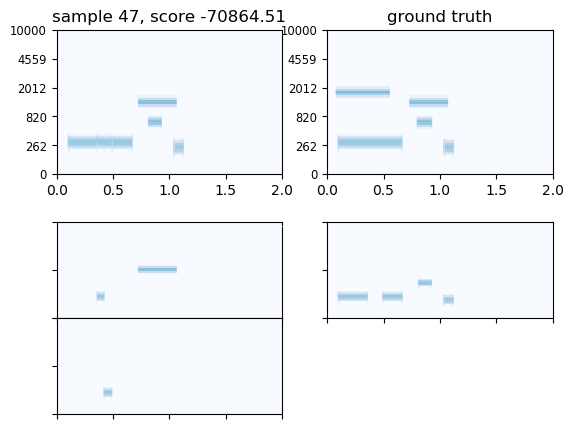

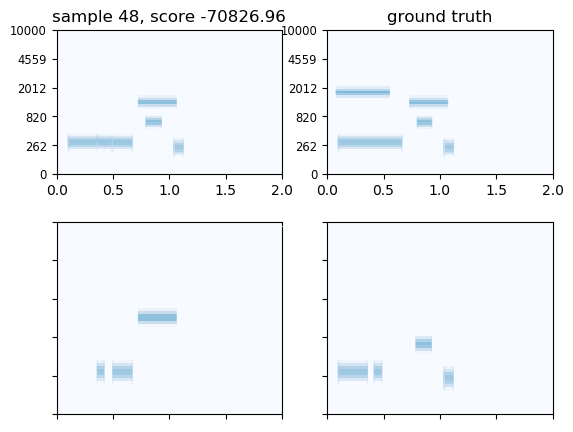

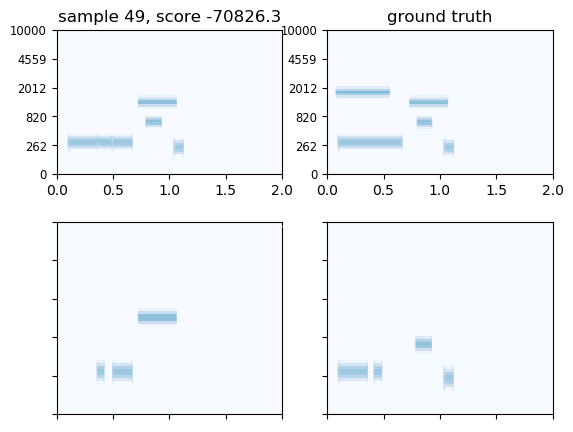

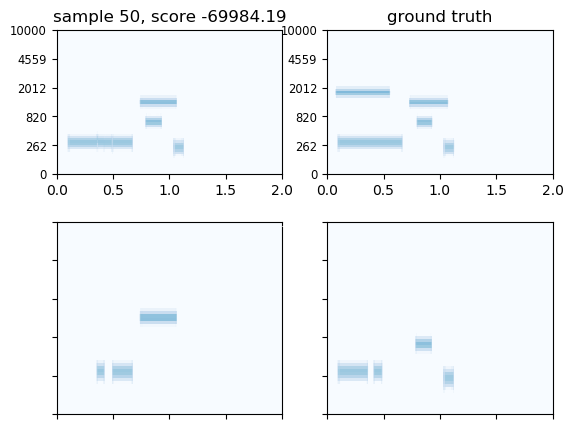

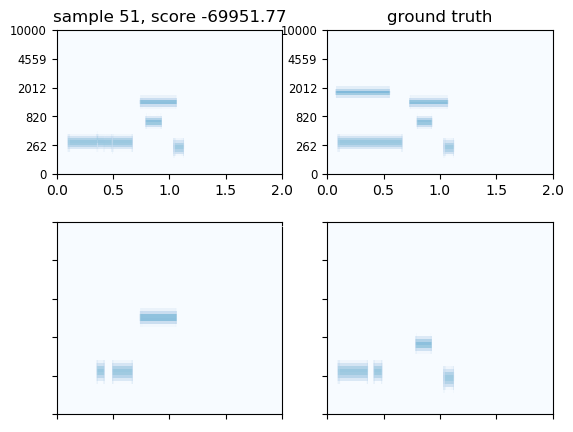

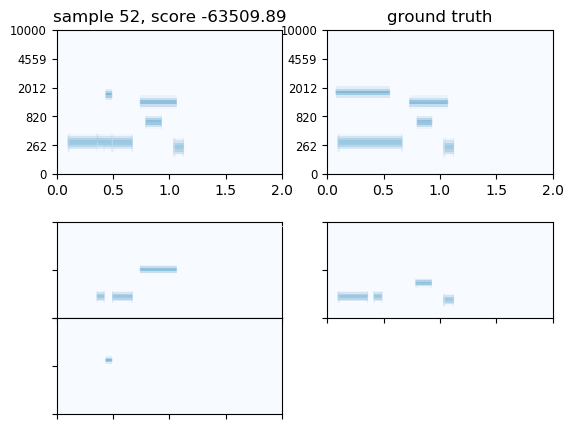

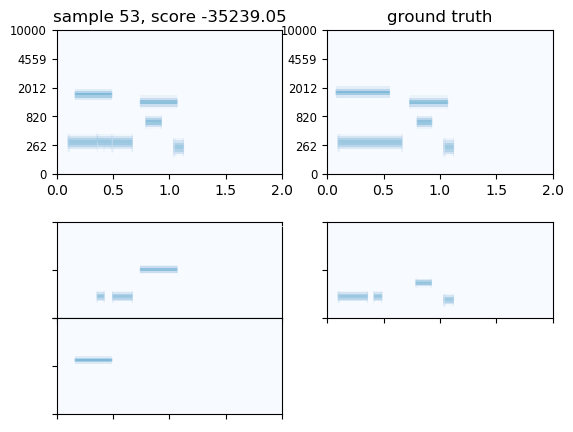

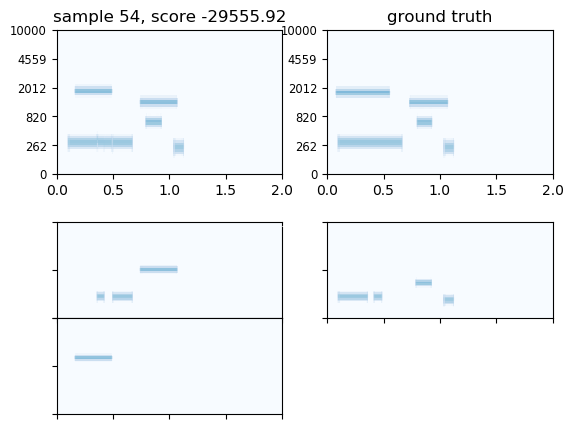

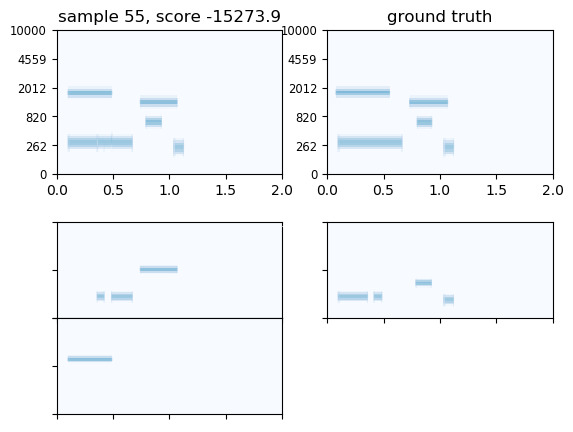

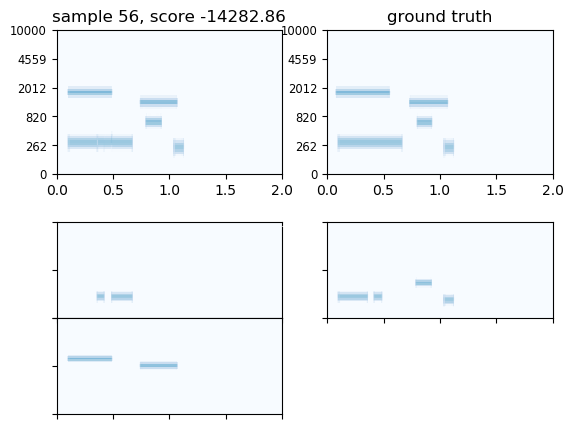

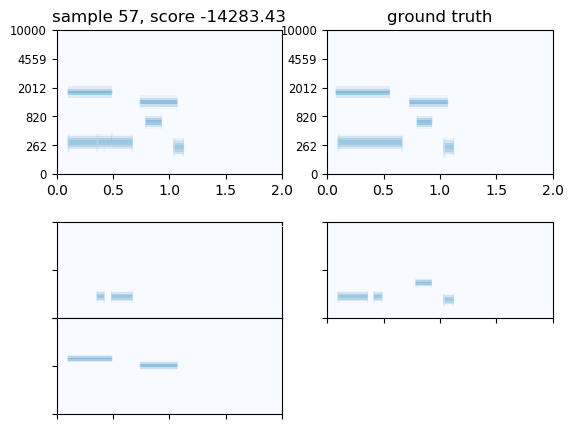

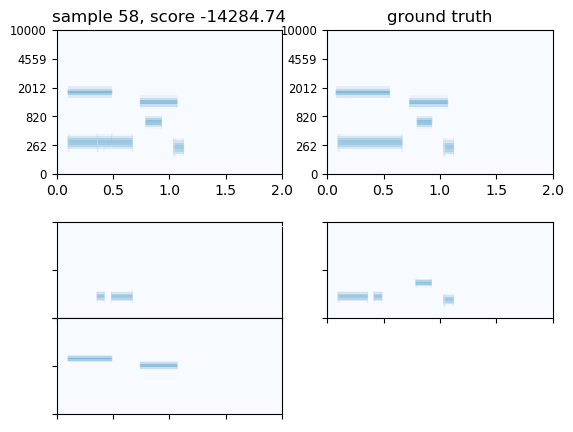

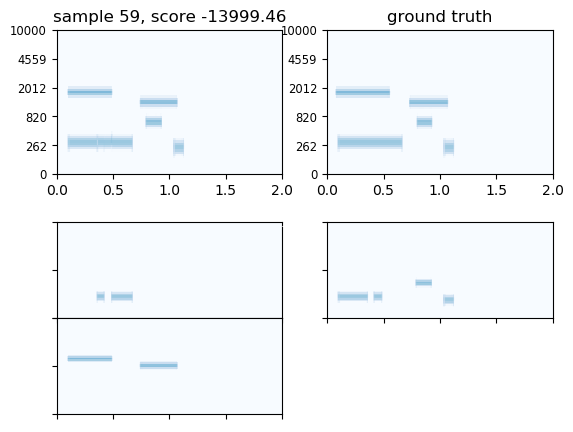

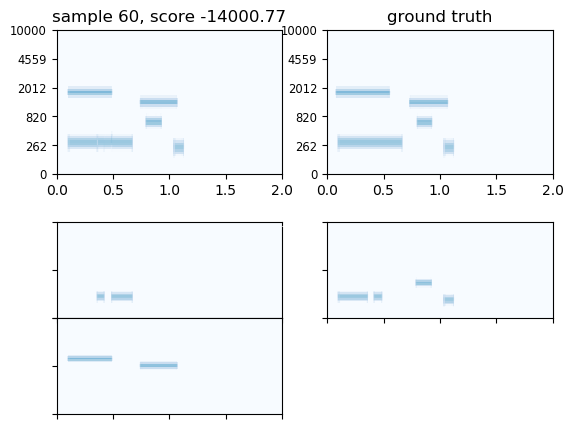

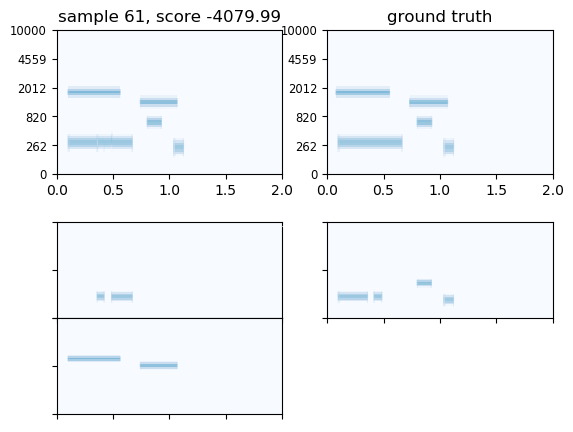

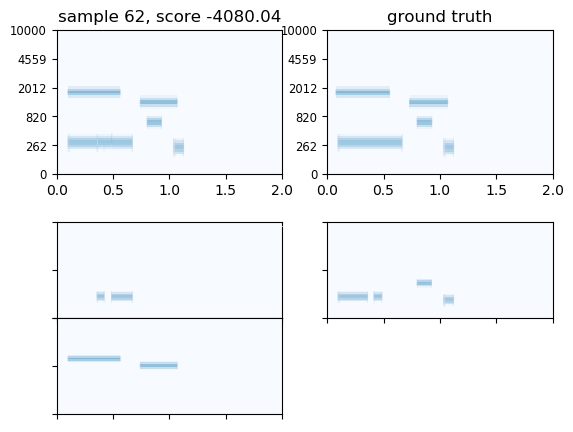

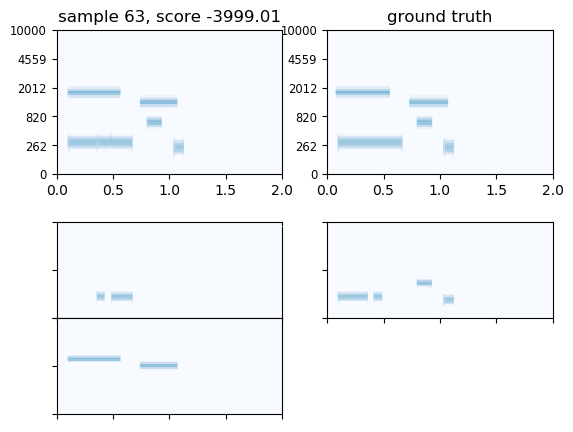

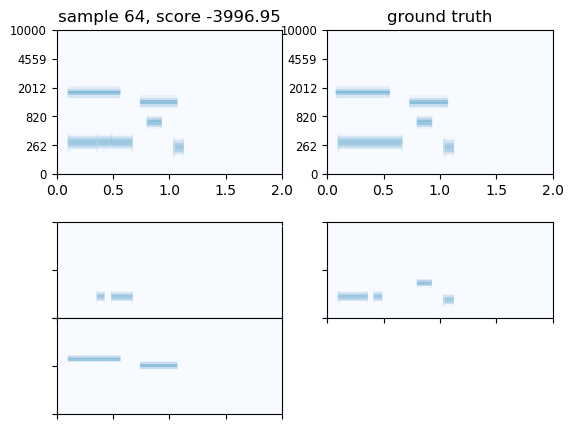

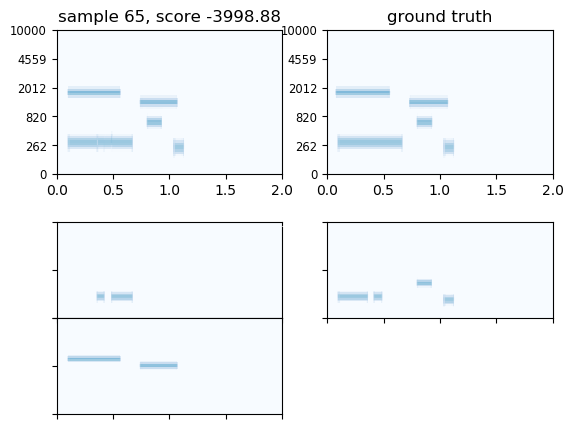

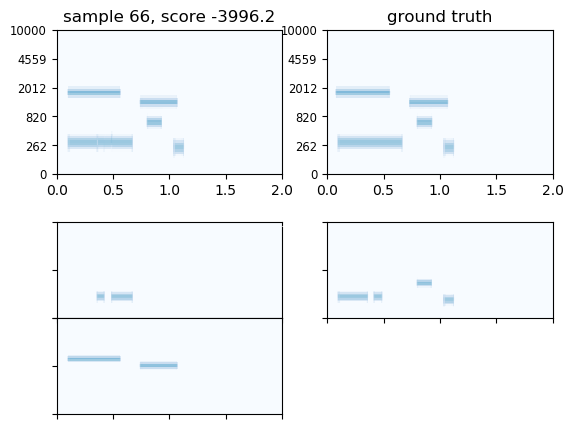

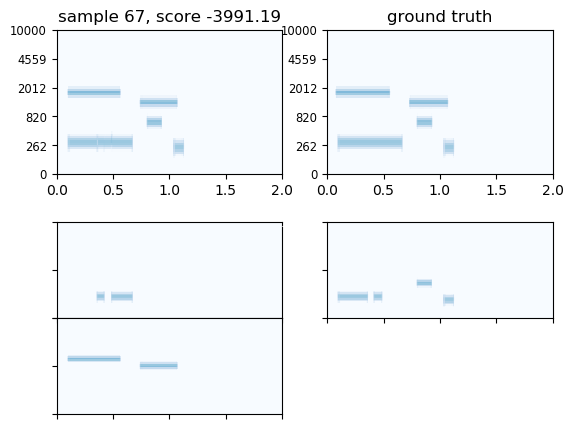

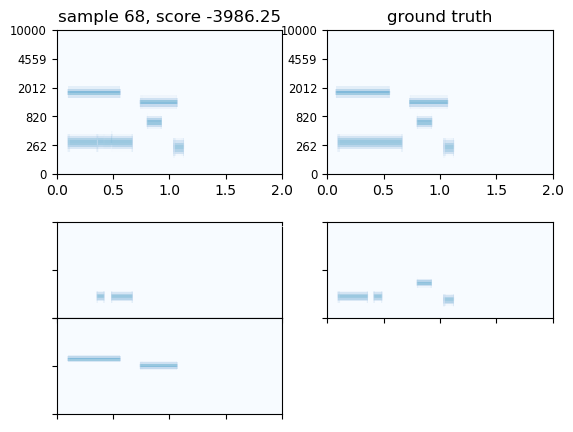

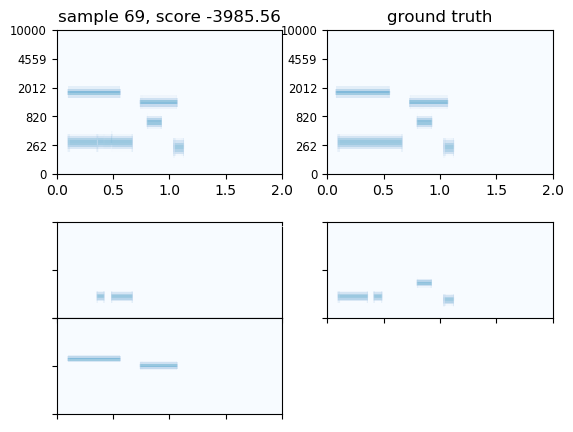

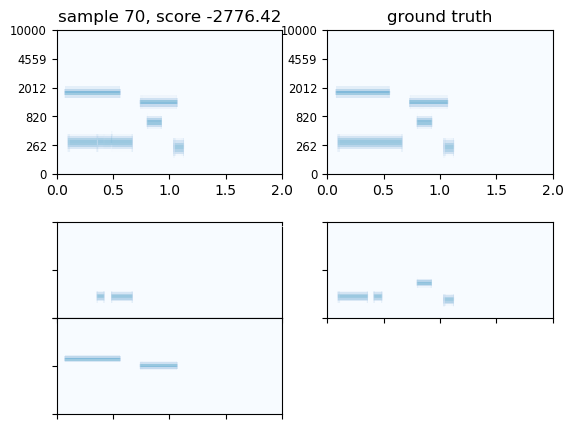

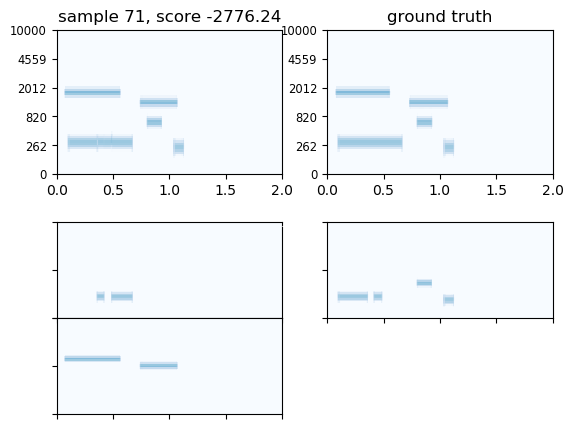

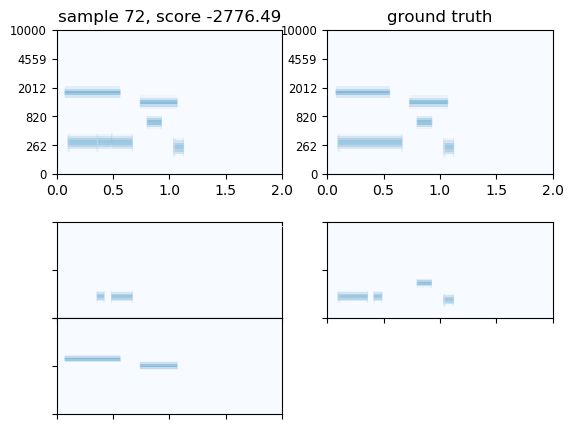

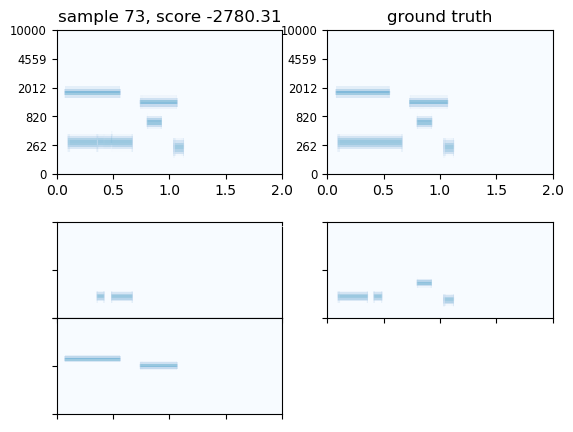

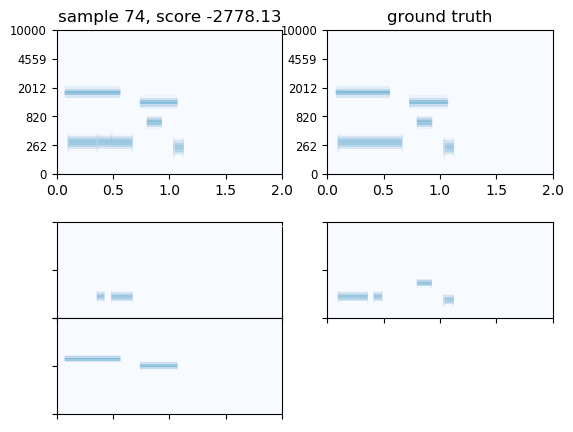

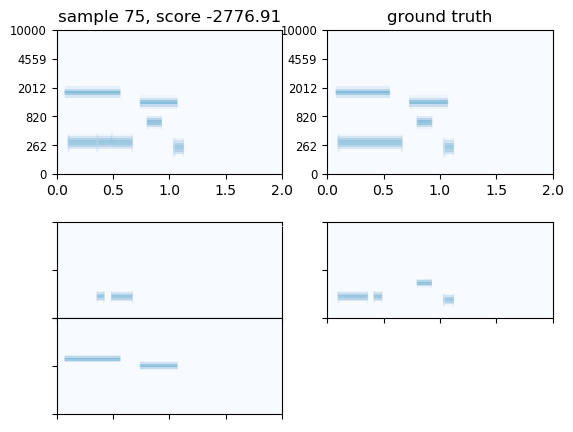

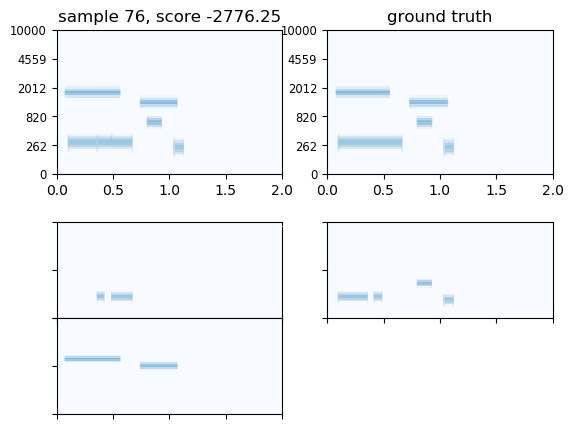

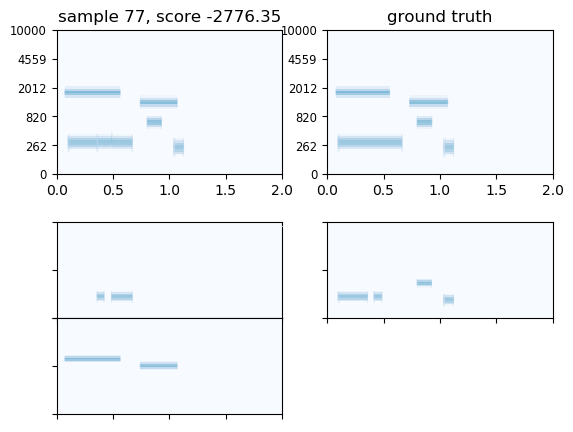

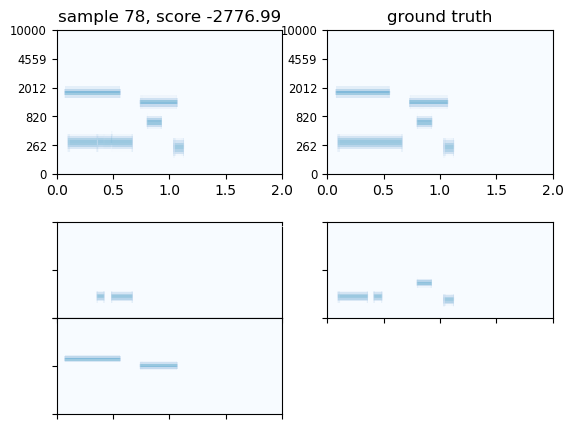

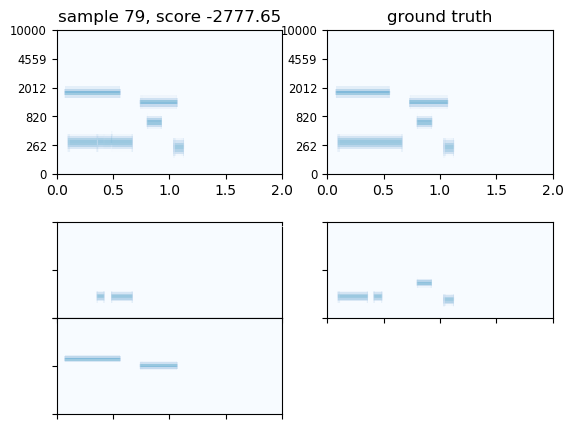

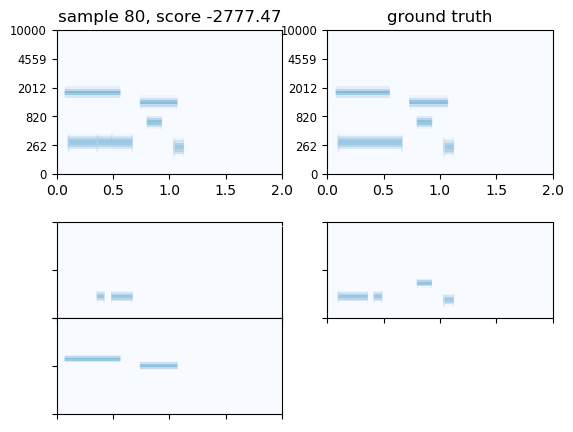

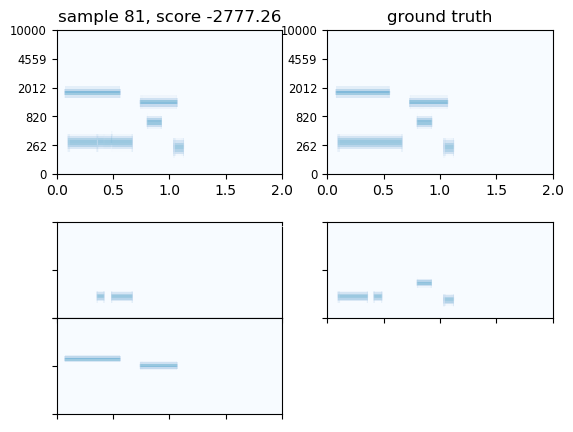

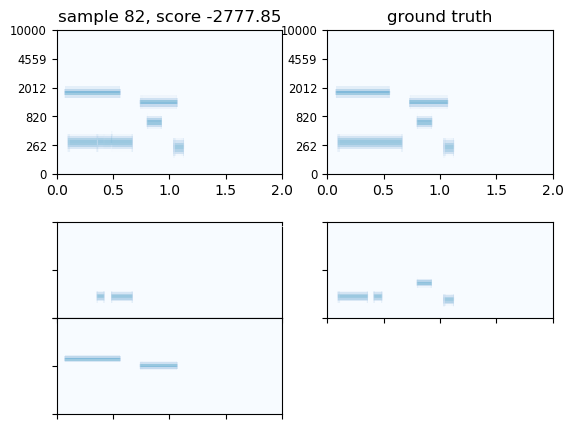

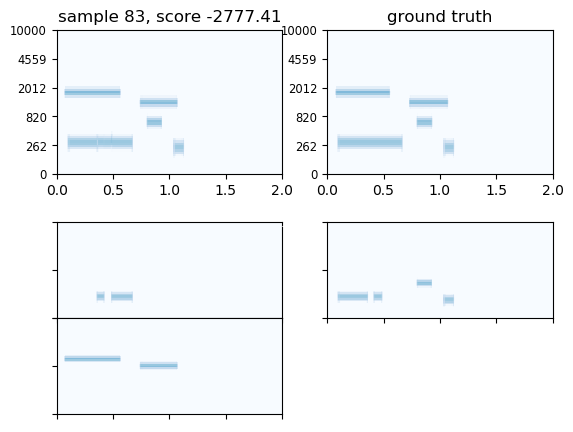

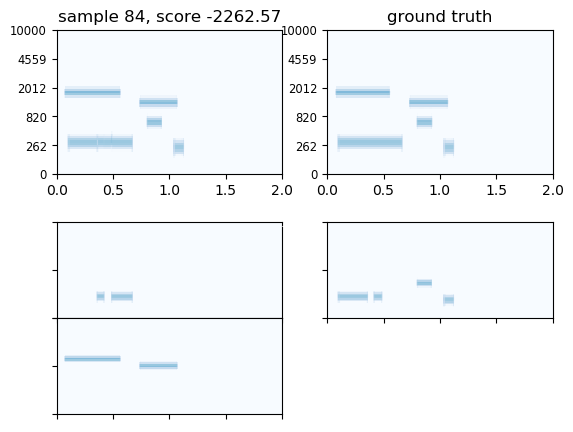

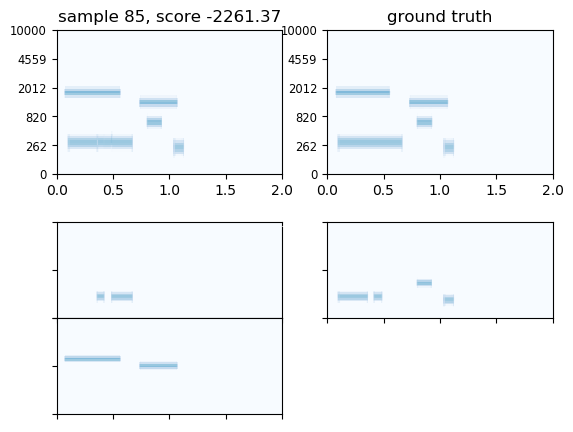

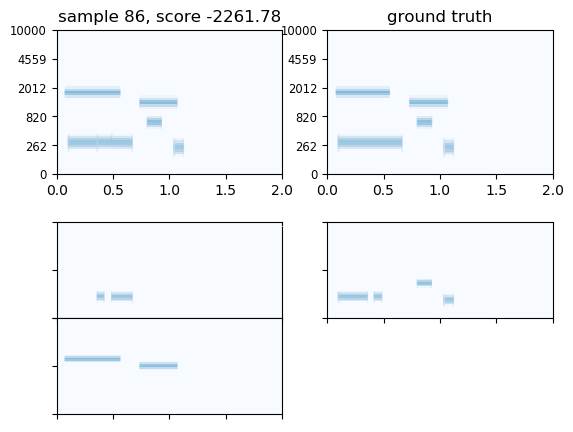

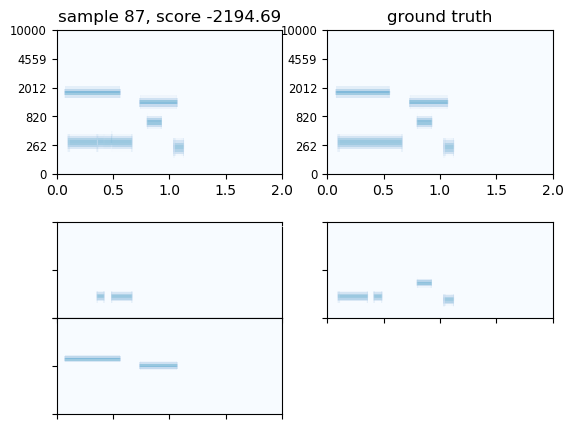

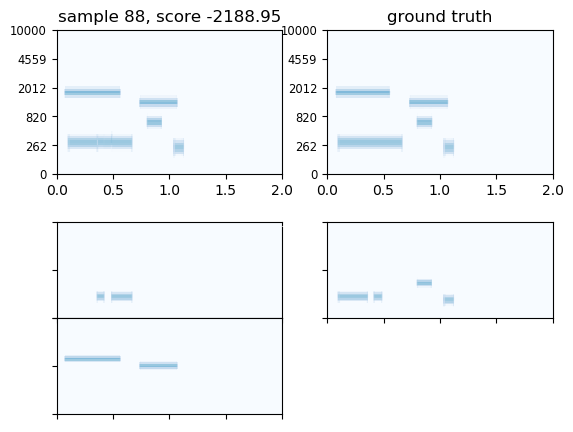

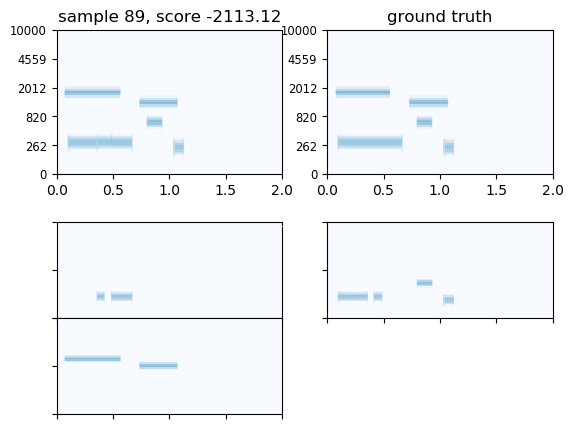

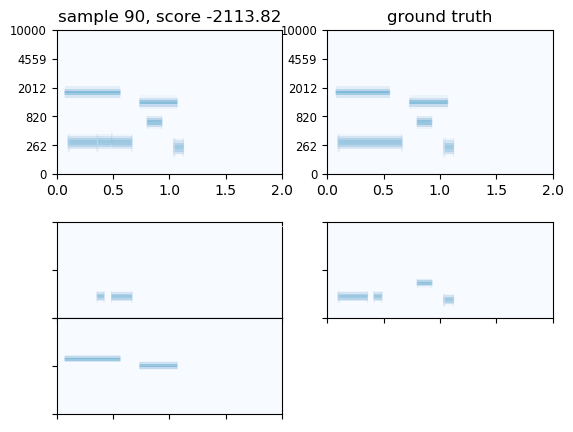

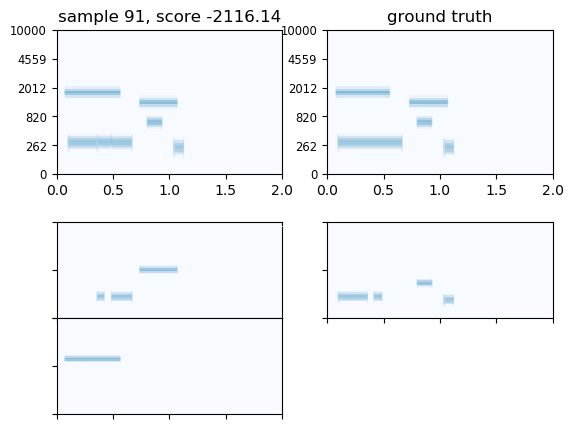

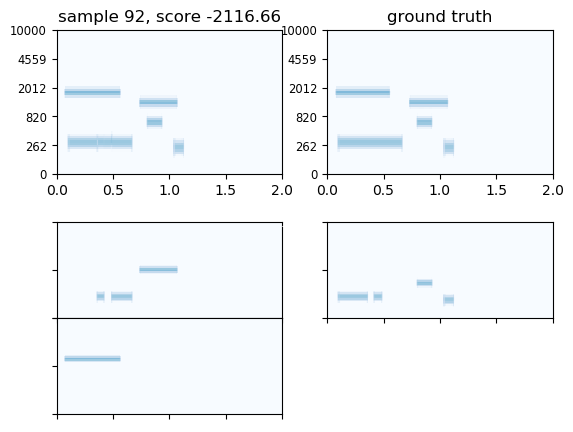

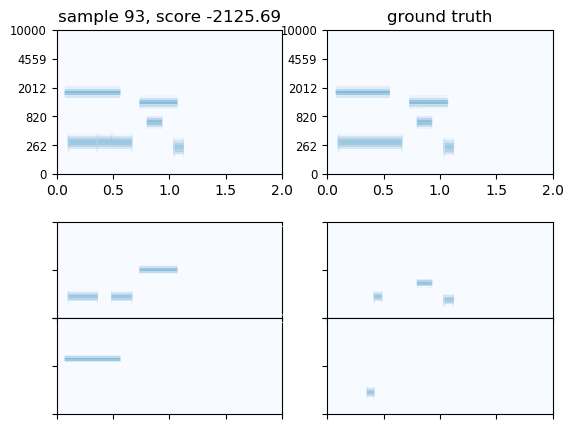

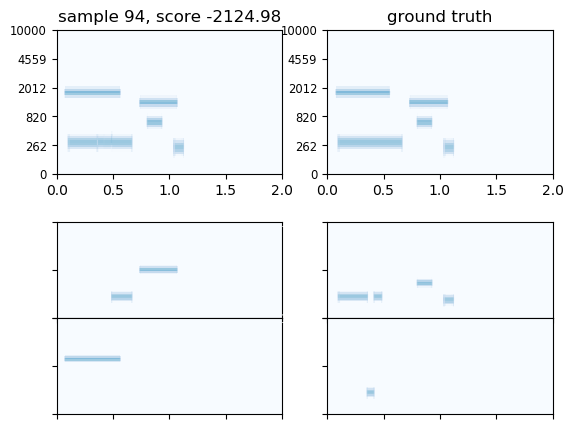

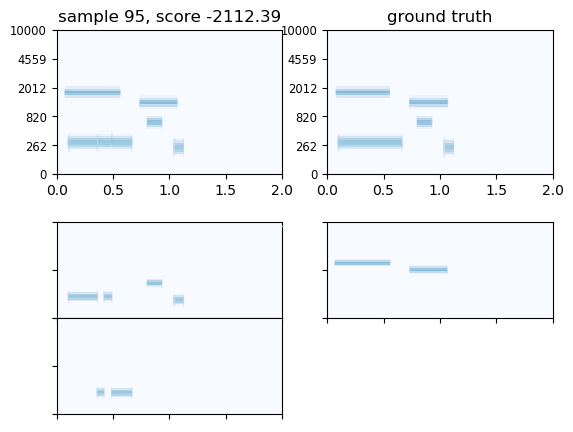

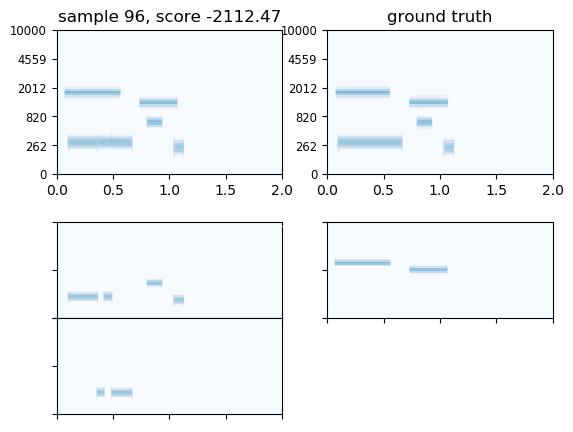

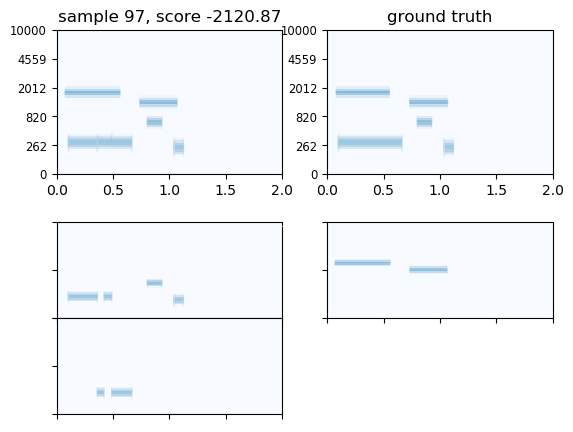

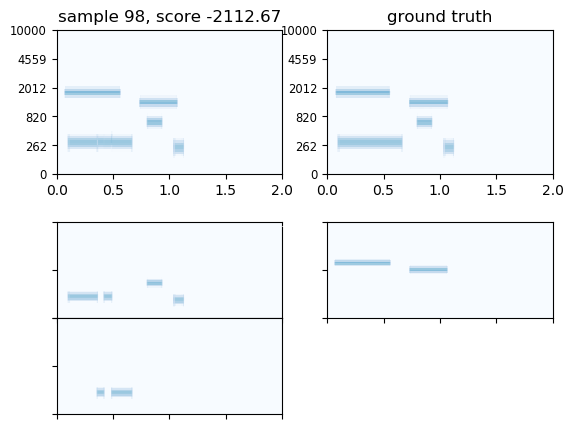

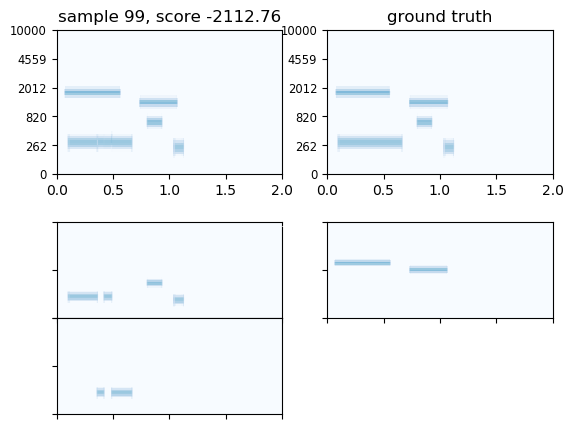

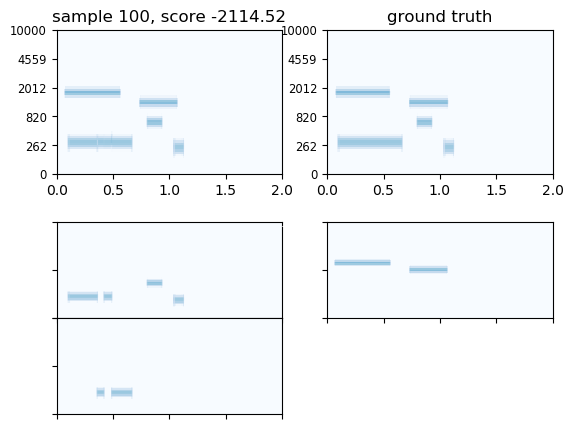

In [93]:
run_inference(scene_gram, args, n_blocks=100);